![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Master Thesis

This project analyzes the causal effect of peace agreements on the intensity of violence, using Double Machine Learning (DML) to control for confounders and handle high-dimensional panel data. We use lagged data to capture delayed effects and fixed effects to control for individual differences between countries.

Below is a follow-along and a close look at our thought processes and logic during the beginning phases of the project. I.e., why we chose the cleaning methods, we chose, the model paramters, etc.

# Table of Contents

1. **[Part 0: Import and Setup](#part0)**
    - Install and import packages
2. **[Part 1: Data Cleaning](#part1)**
    - Clean the panel and pa-x data, merge data and build features
3. **[Part 2: EDA](#part2)**
    - Exploratory Data Analysis
4. **[Part 3: Fixed Effects](#part3)**
    - One hot encoding for country-specific fixed effects
5. **[Part 4: GridSearch](#part4)**
    - Run a GridSearch to find the best hyperparameters
6. **[Part 5: Train and Fit DML](#part5)**
    - Train and fit the models
7. **[Part 6: Sensitivity Analysis with Placebos](#part6)**
    - Sensitivy test to see how reliable our results are
8. **[Part 7: Phased Treatment Analysis](#part7)**
    - Build and test the model with 'phased' treatments

## <a id='part0'>Part 0: Import and Setup</a>

In [1]:
!pip install panelsplit > /dev/null # installation of PanelSplit
!pip install joblib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 1.25.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import pickle

from joblib import Parallel, delayed
import joblib
import datetime
import statsmodels.api as sm
from panelsplit import panelsplit
#https://github.com/4Freye/panelsplit
import itertools
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV,  TimeSeriesSplit
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_score, explained_variance_score, accuracy_score, classification_report, roc_auc_score, accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

import os
# import gc
# from google.colab import drive
# drive.mount('/content/drive/')

# # Set the working directory
# os.chdir('/content/drive/Shareddrives/MasterProject/')

path_out_ = 'Data/'
path_in_ = 'Data/'

from data_processing import *
from utils import *
from modeling import *

## <a id='part1'>Part 1: Data Cleaning</a>

### PA-X Data Cleaning

In [3]:
pax_path = '02 Data/Powersharing/pax_corpus_2003_agreements_18-04-24.csv'
#load the PA-X data
pax_df = pd.read_csv(path_in_ + pax_path)
pax_df.columns = [col.lower() for col in pax_df.columns]

print(pax_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2003 entries, 0 to 2002
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   agreementid               2003 non-null   int64 
 1   version                   2003 non-null   int64 
 2   name                      2003 non-null   object
 3   region                    2003 non-null   object
 4   country                   2003 non-null   object
 5   peace process             2003 non-null   int64 
 6   peace process name        2003 non-null   object
 7   stage                     2003 non-null   object
 8   signed date               2003 non-null   object
 9   agreement/conflict level  2003 non-null   object
 10  conflict nature           2003 non-null   object
 11  agreement status          2003 non-null   object
 12  agreement text            2003 non-null   object
 13  interim arrangement       2003 non-null   object
dtypes: int64(3), object(11)


In [4]:
#we look at all of the different countries found to have peace agreements
unique_countries = pax_df['country'].unique()
print(unique_countries)

['Afghanistan' 'Afghanistan/Pakistan'
 'Afghanistan/United States of America' 'Algeria' 'Angola'
 'Angola/Burundi/Central African Republic/Democratic Republic of Congo/Kenya/Republic of Congo/Rwanda/Sudan/Tanzania/Uganda/Zambia/(African Great Lakes)'
 'Angola/Burundi/Central African Republic/Democratic Republic of Congo/Republic of Congo/Rwanda/South Africa/South Sudan/Tanzania/Uganda/Zambia/(African Great Lakes)'
 'Angola/Cabinda '
 'Angola/Central African Republic/Democratic Republic of Congo/Kenya/Republic of Congo/Rwanda/Sudan/Tanzania/Uganda/Zambia/(African Great Lakes)'
 'Argentina/United Kingdom' 'Armenia/Azerbaijan/Nagorno-Karabakh'
 'Armenia/Azerbaijan/(Nagorno-Karabakh)'
 'Armenia/Azerbaijan/Russia/(Nagorno-Karabakh)' 'Bahrain'
 'Bangladesh/Chittagong Hill Tracts'
 'Bosnia and Herzegovina/Yugoslavia (former)'
 '(Bougainville)/(United Nations)' 'Burundi'
 'Burundi/Democratic Republic of Congo' 'Cambodia' 'Cameroon/Nigeria'
 'Central African Republic' 'Central African Republic/

#### Map countries to isocodes
We can see that some of the country names are not standard and cannot be directly mapped to the iso codes, so we need to do some research and find the correct ISO codes for each

For mapping ISO codes, if an agreement lists multiple countries, we believe it would typically be accurate to associate the agreement with all those countries.

Given the diversity of situations, it can be helpful to map all countries listed in each agreement to their respective ISO codes unless there is clear information indicating that some countries should not be included (like merely hosting a negotiation without being affected by the agreement’s content).

In [5]:
# Load the dictionary from the file
with open(path_out_ + 'peace_process_to_iso.pkl', 'rb') as file:
    peace_process_to_iso = pickle.load(file)

pax_df['isocode'] = pax_df['peace process name'].map(peace_process_to_iso)

In [6]:
# Dictionary mapping country strings to lists of ISO country codes
country_to_iso_codes = {
    'Angola/Burundi/Central African Republic/Democratic Republic of Congo/Kenya/Republic of Congo/Rwanda/Sudan/Tanzania/Uganda/Zambia/(African Great Lakes)':
        ['AGO', 'BDI', 'CAF', 'COD', 'KEN', 'COG', 'RWA', 'SDN', 'TZA', 'UGA', 'ZMB'],

    'Angola/Burundi/Central African Republic/Democratic Republic of Congo/Republic of Congo/Rwanda/South Africa/South Sudan/Tanzania/Uganda/Zambia/(African Great Lakes)':
        ['AGO', 'BDI', 'CAF', 'COD', 'COG', 'RWA', 'ZAF', 'SSD', 'TZA', 'UGA', 'ZMB'],

    'Angola/Cabinda':
        ['AO-CAB'],  # Custom code for Cabinda, subdivision of Angola

    'Angola/Central African Republic/Democratic Republic of Congo/Kenya/Republic of Congo/Rwanda/Sudan/Tanzania/Uganda/Zambia/(African Great Lakes)':
        ['AGO', 'CAF', 'COD', 'KEN', 'COG', 'RWA', 'SDN', 'TZA', 'UGA', 'ZMB'],

    'Croatia/Slovenia/Yugoslavia (former)':
        ['HRV', 'SVN', 'YUG'],

    'Croatia/Yugoslavia (former)':
        ['HRV', 'YUG'],

    'Kurds-Kurdistan':
        ['KRG'],  # Custom code for Kurdistan region

    'Slovenia/Yugoslavia (former)':
        ['SVN', 'YUG']
}

pax_df.loc[pax_df['isocode'].isna(), 'isocode'] = pax_df['country'].map(country_to_iso_codes)

In [7]:
#check the nulls
null_isocodes_sum = pax_df['isocode'].isna().sum()
print("Number of Countries with Null Values")
print(null_isocodes_sum)

#df with only the rows with null isocodes
null_isocodes_df = pax_df[pax_df['isocode'].isna()]

display(null_isocodes_df)

Number of Countries with Null Values
1


,agreementid,version,name,region,country,peace process,peace process name,stage,signed date,agreement/conflict level,conflict nature,agreement status,agreement text,interim arrangement,isocode
46,1336,1,Memorandum of Peace and Understanding in Cabin...,Africa (excl MENA),Angola/Cabinda,137,Cabinda process,SubComp,2006-08-01,Intra,Government/territory,Multiparty signed/agreed,Gazette of the Republic\r\n\r\n \r\n\r\nOffici...,No,NaN


In [8]:
#drop rows where 'isocode' is missing
cleaned_df = pax_df.dropna(subset=['isocode'])
print(cleaned_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2002 entries, 0 to 2002
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   agreementid               2002 non-null   int64 
 1   version                   2002 non-null   int64 
 2   name                      2002 non-null   object
 3   region                    2002 non-null   object
 4   country                   2002 non-null   object
 5   peace process             2002 non-null   int64 
 6   peace process name        2002 non-null   object
 7   stage                     2002 non-null   object
 8   signed date               2002 non-null   object
 9   agreement/conflict level  2002 non-null   object
 10  conflict nature           2002 non-null   object
 11  agreement status          2002 non-null   object
 12  agreement text            2002 non-null   object
 13  interim arrangement       2002 non-null   object
 14  isocode                   200

#### Convert signed date to period

In [9]:
#convert 'signed_date' to datetime and extract period
cleaned_df['signed date'] = pd.to_datetime(cleaned_df['signed date'])
cleaned_df['period'] = cleaned_df['signed date'].dt.strftime('%Y%m').astype(int)

cleaned_df['period'].head()

<ipython-input-9-b20f3344d74f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['signed date'] = pd.to_datetime(cleaned_df['signed date'])
<ipython-input-9-b20f3344d74f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['period'] = cleaned_df['signed date'].dt.strftime('%Y%m').astype(int)


,period
0,201907
1,201802
2,201609
3,201409
4,201207


In [10]:
#check for missing values in the data
print(cleaned_df.isnull().sum())

print()

agreementid                 0
version                     0
name                        0
region                      0
country                     0
peace process               0
peace process name          0
stage                       0
signed date                 0
agreement/conflict level    0
conflict nature             0
agreement status            0
agreement text              0
interim arrangement         0
isocode                     0
period                      0
dtype: int64



### Feature engineering and Data Cleaning: PA-X Data
Here we will build new features
*   Dummy variable for whether a country has at least one peace agreement during specific period
*   Number of agreements in place for that country/period
*   Agreementid (if multiple peace agreements in place, we have a list of the ids)







#### Check to see if there are multiple peace agreements signed in one period

In [11]:
#helper column for counting agreements
cleaned_df['agreement_present'] = 1

#g by 'country' and 'period' and aggregate
aggregated_data = cleaned_df.groupby(['country', 'period']).agg(
    total_agreements=('agreement_present', 'sum')  # Sum to get total agreements
).reset_index()

#find the maximum number of agreements for one period
max_agreements = aggregated_data['total_agreements'].max()

print(f"The maximum number of agreements for one period is: {max_agreements}")

The maximum number of agreements for one period is: 10


<ipython-input-11-0b8752dc5d88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['agreement_present'] = 1


If there is a peace agreement with multiple countries involved (listed in isocode), we will expode into their own seperate rows

In [12]:
filtered_pax = cleaned_df[['agreementid', 'isocode', 'period', 'name']]

#ensure every cell in 'isocode' is a list (in case some are not)
filtered_pax['isocode'] = filtered_pax['isocode'].apply(lambda x: x if isinstance(x, list) else [x])

#explode the 'isocode' lists into separate rows
df_exploded = filtered_pax.explode('isocode')
print(df_exploded)

      agreementid isocode  period  \
0            2232     AFG  201907   
1            2242     AFG  201802   
2            1739     AFG  201609   
3            1923     AFG  201409   
4             864     AFG  201207   
...           ...     ...     ...   
1998          250     YEM  199406   
1999          264     YEM  199004   
2000         1340     ZWE  201303   
2001          826     ZWE  200809   
2002          828     ZWE  200807   

                                                   name  
0     Resolution of Intra Afghan Peace Conference in...  
1     Taliban MoU with department of Helmand on educ...  
2     Agreement between the Islamic Republic of Afgh...  
3     Agreement between the two campaign teams regar...  
4     Tokyo Declaration Partnership for Self-Relianc...  
...                                                 ...  
1998  Agreement on a Ceasefire in the Republic of Yemen  
1999  Agreement Establishing a Union between the Sta...  
2000    Constitution of Zimbabwe 

<ipython-input-12-6d1fee1198d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pax['isocode'] = filtered_pax['isocode'].apply(lambda x: x if isinstance(x, list) else [x])


#### Aggregate data

In [13]:
#helper column for counting agreements
df_exploded['pa_present'] = 1

pax_df_aggregated = df_exploded.groupby(['isocode', 'period']).agg(
    any_agreement=('pa_present', 'max'),  # Check for any agreement (presence)
    num_agreements=('pa_present', 'sum'),  # Count the number of agreements
    agreement_id=('agreementid', lambda x: ', '.join(map(str, x.unique())))  # Convert integers to strings and join
).reset_index()

print(pax_df_aggregated)

     isocode  period  any_agreement  num_agreements agreement_id
0        AFG  199204              1               1          482
1        AFG  199303              1               1          409
2        AFG  199907              1               1          553
3        AFG  200112              1               1          272
4        AFG  200201              1               1          908
...      ...     ...            ...             ...          ...
1521     ZMB  200612              1               1          668
1522     ZMB  201302              1               1          789
1523     ZWE  200807              1               1          828
1524     ZWE  200809              1               1          826
1525     ZWE  201303              1               1         1340

[1526 rows x 5 columns]


In [20]:
panel_path = '00 Hannes Files/merged_1_3_topics15_250_m12_y2023.csv'
#load panel data
df = pd.read_csv(path_in_ + panel_path).query('populationwb != 0')
df.drop(columns=['Unnamed: 0'], inplace=True)

df.head()

,year,month,tokens,obs,sentiment_words,uncertainty,ste_theta0,ste_theta1,ste_theta2,ste_theta3,...,civilwar1,contig_anyviolence,childmortality,populationwb,democracy0,democracy1,democracy2,democracy3,democracy4,democracy5
0,1989,1,35484.0,242.0,1501.7950,6.0,0.116674,0.064620,0.112124,0.027774,...,0.0,1.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1989,2,59247.0,318.0,3028.5050,12.0,0.119341,0.069172,0.079474,0.036702,...,1.0,0.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1989,3,38694.0,229.0,1642.9800,4.0,0.094843,0.051376,0.072050,0.022090,...,0.0,1.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1989,4,31875.0,193.0,1131.9410,2.0,0.097522,0.067324,0.069265,0.022127,...,0.0,1.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1989,5,18180.0,118.0,739.4256,1.0,0.098442,0.065014,0.083056,0.031051,...,0.0,1.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
df['isocode'].head()

,isocode
0,AFG
1,AFG
2,AFG
3,AFG
4,AFG


In [ ]:
#save to csv and check the results
pax_df_aggregated.to_csv(path_in_ + '02 Data/pax_full_clean_V2.csv', index=False)

In [ ]:
#load PA-X data
pax_df_aggregated = pd.read_csv(path_in_ + '02 Data/pax_full_clean_V2.csv')

### Merge PA-X data onto panel data

Build a 'period' column formatted as YYYYMM

In [15]:
#create the period column
df['period'] = (df.year.astype(str) + df.month.astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)).astype(int)
df.columns

Index(['year', 'month', 'tokens', 'obs', 'sentiment_words', 'uncertainty',
       'ste_theta0', 'ste_theta1', 'ste_theta2', 'ste_theta3', 'ste_theta4',
       'ste_theta5', 'ste_theta6', 'ste_theta7', 'ste_theta8', 'ste_theta9',
       'ste_theta10', 'ste_theta11', 'ste_theta12', 'ste_theta13',
       'ste_theta14', 'ste_theta0_stock', 'ste_theta1_stock',
       'ste_theta2_stock', 'ste_theta3_stock', 'ste_theta4_stock',
       'ste_theta5_stock', 'ste_theta6_stock', 'ste_theta7_stock',
       'ste_theta8_stock', 'ste_theta9_stock', 'ste_theta10_stock',
       'ste_theta11_stock', 'ste_theta12_stock', 'ste_theta13_stock',
       'ste_theta14_stock', 'sentiment_stock', 'uncertainty_index', 'isocode',
       'best', 'ged_best_ns', 'ged_best_os', 'ged_best_sb', 'anyviolence',
       'armedconf', 'civilwar', 'past6', 'past12', 'past60', 'past120',
       'anyviolence_dp', 'armedconf_dp', 'civilwar_dp', 'ged_best_ns_dp',
       'ged_best_os_dp', 'ged_best_sb_dp', 'ons_anyviolence1',
       

In [16]:
df = df.merge(pax_df_aggregated, on=['isocode', 'period'], how='left')

df.head()

,year,month,tokens,obs,sentiment_words,uncertainty,ste_theta0,ste_theta1,ste_theta2,ste_theta3,...,democracy0,democracy1,democracy2,democracy3,democracy4,democracy5,period,any_agreement,num_agreements,agreement_id
0,1989,1,35484.0,242.0,1501.7950,6.0,0.116674,0.064620,0.112124,0.027774,...,0.0,1.0,0.0,0.0,0.0,0.0,198901,NaN,NaN,NaN
1,1989,2,59247.0,318.0,3028.5050,12.0,0.119341,0.069172,0.079474,0.036702,...,0.0,1.0,0.0,0.0,0.0,0.0,198902,NaN,NaN,NaN
2,1989,3,38694.0,229.0,1642.9800,4.0,0.094843,0.051376,0.072050,0.022090,...,0.0,1.0,0.0,0.0,0.0,0.0,198903,NaN,NaN,NaN
3,1989,4,31875.0,193.0,1131.9410,2.0,0.097522,0.067324,0.069265,0.022127,...,0.0,1.0,0.0,0.0,0.0,0.0,198904,NaN,NaN,NaN
4,1989,5,18180.0,118.0,739.4256,1.0,0.098442,0.065014,0.083056,0.031051,...,0.0,1.0,0.0,0.0,0.0,0.0,198905,NaN,NaN,NaN


In [17]:
print(df[df['any_agreement'] == 1])

       year  month    tokens    obs  sentiment_words  uncertainty  ste_theta0  \
39     1992      4   33210.0  203.0       2166.99900          7.0    0.126020   
50     1993      3    6555.0   66.0        393.12200          0.0    0.044624   
126    1999      7   15725.0  104.0        783.64870          0.0    0.054831   
155    2001     12  137360.0  792.0       7451.67000          8.0    0.138454   
156    2002      1  131621.0  796.0       6476.63000         13.0    0.110463   
...     ...    ...       ...    ...              ...          ...         ...   
81801  2006     12     295.0    3.0         16.42834          0.0    0.010702   
81875  2013      2    1662.0    9.0         11.89976          0.0    0.113760   
82240  2008      7   87625.0  366.0       3369.52000          7.0    0.143706   
82242  2008      9   60894.0  223.0       2758.78000         11.0    0.171752   
82296  2013      3   31941.0  148.0       1525.86200          1.0    0.124740   

       ste_theta1  ste_thet

### Impute Missing Data



First we group by country, compute the mean and fill in missing values with the mean of the group

In [ ]:
#impute missing values using mean of grouped data by country
columns_to_impute = ['tokens', 'obs', 'sentiment_words', 'uncertainty',
       'ste_theta0', 'ste_theta1', 'ste_theta2', 'ste_theta3', 'ste_theta4',
       'ste_theta5', 'ste_theta6', 'ste_theta7', 'ste_theta8', 'ste_theta9',
       'ste_theta10', 'ste_theta11', 'ste_theta12', 'ste_theta13',
       'ste_theta14', 'ste_theta0_stock', 'ste_theta1_stock',
       'ste_theta2_stock', 'ste_theta3_stock', 'ste_theta4_stock',
       'ste_theta5_stock', 'ste_theta6_stock', 'ste_theta7_stock',
       'ste_theta8_stock', 'ste_theta9_stock', 'ste_theta10_stock',
       'ste_theta11_stock', 'ste_theta12_stock', 'ste_theta13_stock',
       'ste_theta14_stock', 'sentiment_stock', 'uncertainty_index', 'democracy0',
       'democracy1', 'democracy2', 'democracy3', 'democracy4', 'democracy5', ]

grouped = df.groupby(['isocode'])[columns_to_impute].transform(lambda x: x.fillna(x.mean()))

#assign the imputed values back to the original DataFrame for all specified columns
df[columns_to_impute] = grouped

In [ ]:
columns_to_ffill = ['childmortality', 'populationwb']

#forward fill within each group to respect group boundaries
for column in columns_to_ffill:
    df[column] = df.groupby(['isocode','year'])[column].fillna(method='ffill')

<ipython-input-266-b771b61d83b0>:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[column] = df.groupby(['isocode','year'])[column].fillna(method='ffill')
<ipython-input-266-b771b61d83b0>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df.groupby(['isocode','year'])[column].fillna(method='ffill')
<ipython-input-266-b771b61d83b0>:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[column] = df.groupby(['isocode','year'])[column].fillna(method='ffill')
<ipython-input-266-b771b61d83b0>:5: FutureWarning: Series.fillna wit

### Build Features

- We build new columns counting periods SINCE violence and UNTIL violence
- We build 'onset within x months' versions of the target variables (in case we want to analyze the onset as our target variable)

In [ ]:
df.head()

,year,month,tokens,obs,sentiment_words,uncertainty,ste_theta0,ste_theta1,ste_theta2,ste_theta3,...,democracy0,democracy1,democracy2,democracy3,democracy4,democracy5,period,any_agreement,num_agreements,agreement_id
0,1989,1,35484.0,242.0,1501.7950,6.0,0.116674,0.064620,0.112124,0.027774,...,0.0,1.0,0.0,0.0,0.0,0.0,198901,NaN,NaN,NaN
1,1989,2,59247.0,318.0,3028.5050,12.0,0.119341,0.069172,0.079474,0.036702,...,0.0,1.0,0.0,0.0,0.0,0.0,198902,NaN,NaN,NaN
2,1989,3,38694.0,229.0,1642.9800,4.0,0.094843,0.051376,0.072050,0.022090,...,0.0,1.0,0.0,0.0,0.0,0.0,198903,NaN,NaN,NaN
3,1989,4,31875.0,193.0,1131.9410,2.0,0.097522,0.067324,0.069265,0.022127,...,0.0,1.0,0.0,0.0,0.0,0.0,198904,NaN,NaN,NaN
4,1989,5,18180.0,118.0,739.4256,1.0,0.098442,0.065014,0.083056,0.031051,...,0.0,1.0,0.0,0.0,0.0,0.0,198905,NaN,NaN,NaN


In [ ]:
term_thresholds = ['anyviolence', 'armedconf', 'civilwar']
df['best'] = df['best'].fillna(0)
df['bestpc'] = df.best * 100000/df.populationwb

#build since and until variables
for term in term_thresholds:
    df[f'since_{term}'] = (df.groupby(['isocode'])[term].transform(data_processing.count_since_target_one))
    if term == 'armedconf':
        df[f'until_{term}'] = (df.groupby(['isocode'])[term].transform(data_processing.count_until_target))

df['any_agreement'] = df['any_agreement'].fillna(0)
df['since_agreement'] = (df.groupby(['isocode'])['any_agreement'].transform(data_processing.count_since_target_one))
df['until_agreement'] = (df.groupby(['isocode'])['any_agreement'].transform(data_processing.count_until_target))

print('since and until created')
### Target Variable Creation
# creates "onset within x months" version of the target variable. It is np.nan if target == 1.
horizons = [6]
for h in horizons:
    for t in term_thresholds:
        df[f'ons_{t}_{h}'] = df.groupby(['isocode'])[t].transform(lambda x: data_processing.onset_in_target_zero(x, h))

since and until created


Build peace agreement lag variables (1-12 months)

In [ ]:
#sort by country and period
df.sort_values(by=['isocode', 'period'], inplace=True)

#create lagged variables for 'any_agreement' within each country
for i in range(1, 13):
    df[f'pa_lag{i}'] = df.groupby('isocode')['any_agreement'].shift(i)

print(df[['isocode', 'period', 'any_agreement'] + [f'pa_lag{i}' for i in range(1, 13)]].head())

  isocode  period  any_agreement  pa_lag1  pa_lag2  pa_lag3  pa_lag4  pa_lag5  \
0     AFG  198901            0.0      NaN      NaN      NaN      NaN      NaN   
1     AFG  198902            0.0      0.0      NaN      NaN      NaN      NaN   
2     AFG  198903            0.0      0.0      0.0      NaN      NaN      NaN   
3     AFG  198904            0.0      0.0      0.0      0.0      NaN      NaN   
4     AFG  198905            0.0      0.0      0.0      0.0      0.0      NaN   

   pa_lag6  pa_lag7  pa_lag8  pa_lag9  pa_lag10  pa_lag11  pa_lag12  
0      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
1      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
2      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
3      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
4      NaN      NaN      NaN      NaN       NaN       NaN       NaN  


In [ ]:
df = df.rename(columns={'any_agreement': 'pa_lag0'})

Build lag variables X

In [ ]:
#drop rows where 'populationwb' is NA
df = df.dropna(subset=['populationwb'])

#create lags for the covariates
df.sort_values(by=['isocode', 'period'], inplace=True)

covariates = ['since_anyviolence', 'since_armedconf', 'since_civilwar', 'tokens', 'obs', 'sentiment_words', 'uncertainty',
              'ste_theta0', 'ste_theta1', 'ste_theta2', 'ste_theta3',
                 'ste_theta4', 'ste_theta5', 'ste_theta6', 'ste_theta7',
                 'ste_theta8', 'ste_theta9', 'ste_theta10', 'ste_theta11',
                 'ste_theta12', 'ste_theta13', 'ste_theta14',
              'ste_theta0_stock', 'ste_theta1_stock', 'ste_theta2_stock', 'ste_theta3_stock', 'ste_theta4_stock',
              'ste_theta5_stock', 'ste_theta6_stock', 'ste_theta7_stock', 'ste_theta8_stock', 'ste_theta9_stock',
              'ste_theta10_stock', 'ste_theta11_stock', 'ste_theta12_stock', 'ste_theta13_stock', 'ste_theta14_stock',
              'sentiment_stock', 'populationwb']

df[covariates] = df[covariates].fillna(0)
number_of_lags = 13
new_columns = {}

for cov in covariates:
    for lag in range(1, number_of_lags):
        new_columns[f'{cov}_lag{lag}'] = df.groupby('isocode')[cov].shift(lag)

df = pd.concat([df, pd.DataFrame(new_columns, index=df.index)], axis=1)
df[list(new_columns.keys())] = df[list(new_columns.keys())].fillna(0)

rename_dict = {col: f"{col}_lag0" for col in covariates}

df = df.rename(columns=rename_dict)

df.head()

<ipython-input-271-1258aac789ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['isocode', 'period'], inplace=True)


,year,month,tokens_lag0,obs_lag0,sentiment_words_lag0,uncertainty_lag0,ste_theta0_lag0,ste_theta1_lag0,ste_theta2_lag0,ste_theta3_lag0,...,populationwb_lag3,populationwb_lag4,populationwb_lag5,populationwb_lag6,populationwb_lag7,populationwb_lag8,populationwb_lag9,populationwb_lag10,populationwb_lag11,populationwb_lag12
0,1989,1,35484.0,242.0,1501.7950,6.0,0.116674,0.064620,0.112124,0.027774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1989,2,59247.0,318.0,3028.5050,12.0,0.119341,0.069172,0.079474,0.036702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1989,3,38694.0,229.0,1642.9800,4.0,0.094843,0.051376,0.072050,0.022090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1989,4,31875.0,193.0,1131.9410,2.0,0.097522,0.067324,0.069265,0.022127,...,11868877.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1989,5,18180.0,118.0,739.4256,1.0,0.098442,0.065014,0.083056,0.031051,...,11868877.0,11868877.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Build our target variable (target intensity)
- log(violence + 1)

In [ ]:
violence_intensity = np.log(df['bestpc'] + 1).fillna(0)
df = pd.concat([df, violence_intensity.rename('violence_intensity')], axis=1)

df = df.copy()

In [ ]:
# save if needed
df.to_csv(path_out_ + 'data_clean_with_lagsV2.csv', index=False)

In [ ]:
# load df if needed
df = pd.read_csv(path_out_ + 'data_clean_with_lagsV2.csv')
df.head()

<ipython-input-15-bcbcbc001593>:2: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_out_ + 'data_clean_with_lagsV2.csv')


,year,month,tokens_lag0,obs_lag0,sentiment_words_lag0,uncertainty_lag0,ste_theta0_lag0,ste_theta1_lag0,ste_theta2_lag0,ste_theta3_lag0,...,populationwb_lag4,populationwb_lag5,populationwb_lag6,populationwb_lag7,populationwb_lag8,populationwb_lag9,populationwb_lag10,populationwb_lag11,populationwb_lag12,violence_intensity
0,1989,1,35484.0,242.0,1501.7950,6.0,0.116674,0.064620,0.112124,0.027774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.948155
1,1989,2,59247.0,318.0,3028.5050,12.0,0.119341,0.069172,0.079474,0.036702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.853591
2,1989,3,38694.0,229.0,1642.9800,4.0,0.094843,0.051376,0.072050,0.022090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.753272
3,1989,4,31875.0,193.0,1131.9410,2.0,0.097522,0.067324,0.069265,0.022127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.641352
4,1989,5,18180.0,118.0,739.4256,1.0,0.098442,0.065014,0.083056,0.031051,...,11868877.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.573838


Build Onset variables for 3 and 6 months, variable tells us if there will be treatment put in place within 3 and 6 months

In [ ]:
# # Sort by country and period
# df.sort_values(by=['isocode', 'period'], inplace=True)

# # Create rolling windows to check for agreements within 3 and 6 months
# df['pa_within_3_months'] = df.groupby('isocode')['pa_lag0'].transform(lambda x: x.rolling(3, min_periods=1).max())
# df['pa_within_6_months'] = df.groupby('isocode')['pa_lag0'].transform(lambda x: x.rolling(6, min_periods=1).max())

# print(df[['isocode', 'period', 'pa_within_3_months', 'pa_within_6_months']])

      isocode  period  pa_within_3_months  pa_within_6_months
0         AFG  198901                 0.0                 0.0
1         AFG  198902                 0.0                 0.0
2         AFG  198903                 0.0                 0.0
3         AFG  198904                 0.0                 0.0
4         AFG  198905                 0.0                 0.0
...       ...     ...                 ...                 ...
82421     ZWE  202308                 0.0                 0.0
82422     ZWE  202309                 0.0                 0.0
82423     ZWE  202310                 0.0                 0.0
82424     ZWE  202311                 0.0                 0.0
82425     ZWE  202312                 0.0                 0.0

[80776 rows x 4 columns]


In [ ]:
# covariates = ['populationwb', 'since_anyviolence', 'since_armedconf', 'since_civilwar', 'tokens', 'obs', 'sentiment_words', 'uncertainty',
#               'ste_theta0_stock', 'ste_theta1_stock', 'ste_theta2_stock', 'ste_theta3_stock', 'ste_theta4_stock',
#               'ste_theta5_stock', 'ste_theta6_stock', 'ste_theta7_stock', 'ste_theta8_stock', 'ste_theta9_stock',
#               'ste_theta10_stock', 'ste_theta11_stock', 'ste_theta12_stock', 'ste_theta13_stock', 'ste_theta14_stock',
#               'sentiment_stock']

# # Fill missing covariate values with 0 (or an appropriate value)
# df[covariates] = df[covariates].fillna(0)

# # Aggregate covariates and violence intensity within 3 months and 6 months
# for cov in covariates + ['violence_intensity']:
#     df[f'{cov}_within_3_months'] = df.groupby('isocode')[cov].transform(lambda x: x.rolling(3, min_periods=1).mean())
#     df[f'{cov}_within_6_months'] = df.groupby('isocode')[cov].transform(lambda x: x.rolling(6, min_periods=1).mean())

# print(df[[f'{cov}_within_3_months' for cov in covariates + ['violence_intensity']]].head())
# print(df[[f'{cov}_within_6_months' for cov in covariates + ['violence_intensity']]].head())


   populationwb_within_3_months  since_anyviolence_within_3_months  \
0                    11868877.0                                0.0   
1                    11868877.0                                0.0   
2                    11868877.0                                0.0   
3                    11868877.0                                0.0   
4                    11868877.0                                0.0   

   since_armedconf_within_3_months  since_civilwar_within_3_months  \
0                              0.0                        0.000000   
1                              0.0                        0.500000   
2                              0.0                        0.333333   
3                              0.0                        0.666667   
4                              0.0                        1.000000   

   tokens_within_3_months  obs_within_3_months  \
0                 35484.0           242.000000   
1                 47365.5           280.000000   
2       

## <a id='part2'>Part 2: EDA</a>

### Target Distribution Analysis

In [ ]:
descriptive_stats = df['bestpc'].describe()
print(descriptive_stats)

count    80776.000000
mean         0.348629
std         44.089389
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      12484.221971
Name: bestpc, dtype: float64


Looking at the descriptive stats for 'bestpc' (best percentage of deaths per captia), we can see a huge descrepency between the min and max. This skews our data to the right. Below we can visually see this in the distribution.

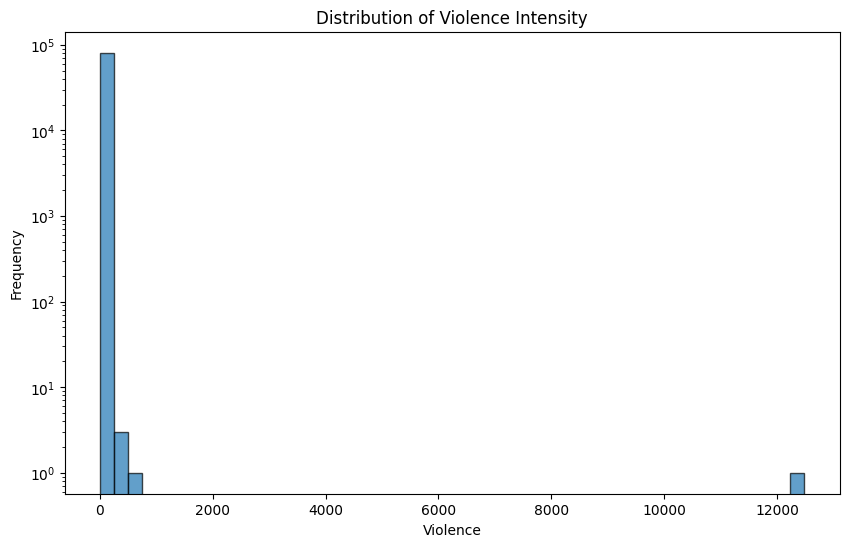

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['bestpc'], bins=50, edgecolor='k', alpha=0.7)
plt.yscale('log')  # Log scale to handle the skewness
plt.xlabel('Violence')
plt.ylabel('Frequency')
plt.title('Distribution of Violence Intensity')
plt.show()

Now, let's look at 'violence_intensity' which is just a log transformation 'bestpc'. This should help normalize and stabalize the data.

count    80776.000000
mean         0.055121
std          0.275581
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.432301
Name: violence_intensity, dtype: float64


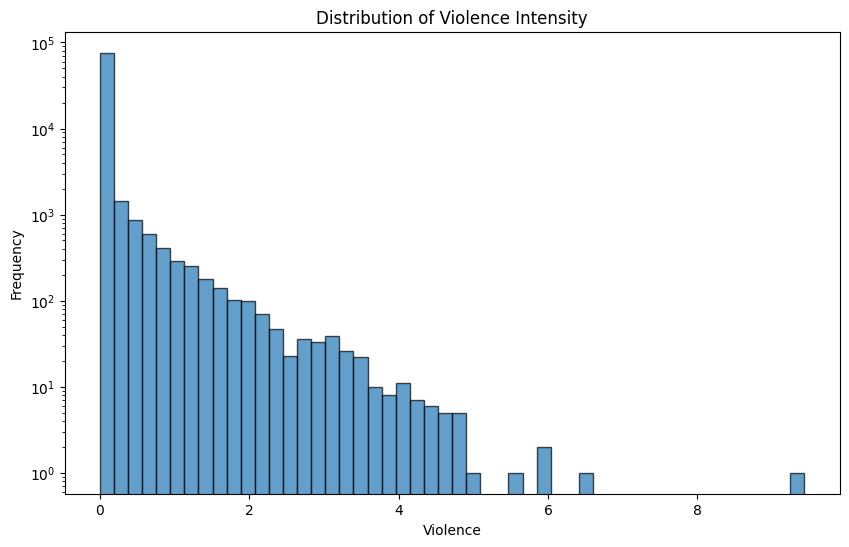

In [ ]:
descriptive_stats = df['violence_intensity'].describe()
print(descriptive_stats)

#plot distribution for violence intensity
plt.figure(figsize=(10, 6))
plt.hist(df['violence_intensity'], bins=50, edgecolor='k', alpha=0.7)
plt.yscale('log')  # Log scale to handle the skewness
plt.xlabel('Violence')
plt.ylabel('Frequency')
plt.title('Distribution of Violence Intensity')
plt.show()

We can now see the range between min and max has been reduced and the data distribution looks slightly better than the one above.

In this case, we can not just drop outliers because every peice of data we have counts when we have observational data with highly imbalanced data.

### Feature Distribution Analysis

Next, we look at the descriptive stats for each of the new topics.
The dataset we're working with includes several key features that provide insights into the distribution of topics in news articles over time. The ste_theta1 to ste_theta15 variables represent the proportion of each topic (1 through 15) within news articles about a particular country during a given month. These values indicate how prevalent each topic is in the context of news coverage for that time period.

Additionally, the dataset includes ste_theta1_stock to ste_theta15_stock, which are similar to the original topic proportions but have been adjusted using an exponentially weighted moving average (EWMA) for each country. This adjustment smooths the data, giving more weight to recent observations, which can be useful for capturing trends or shifts in the focus of news coverage over time.

The Tokens variable reflects the total number of words written in articles about a country in a given month, providing a measure of the volume of content. The obs variable indicates the number of articles published about the country during the same period. Together, these variables offer a quantitative view of media attention and can help in understanding how the focus on specific topics correlates with the volume and frequency of coverage.

In [ ]:
#df with original ste_theta topics, renamed
topic_names = {
    'ste_theta0': 'Change',
    'ste_theta1': 'Cooperation',
    'ste_theta2': 'Defense',
    'ste_theta3': 'Politics',
    'ste_theta4': 'Economy',
    'ste_theta5': 'Legal Proceedings',
    'ste_theta6': 'Conflict Zones',
    'ste_theta7': 'Development Projects',
    'ste_theta8': 'Sports',
    'ste_theta9': 'Human Rights',
    'ste_theta10': 'Military Operations',
    'ste_theta11': 'Family & Social Life',
    'ste_theta12': 'War & International Conflict',
    'ste_theta13': 'Government & Policy',
    'ste_theta14': 'Public Health & Safety'
}

#filter
df_thetas = df[[f'ste_theta{i}' for i in range(0, 15)]]
#rename
df_thetas.rename(columns=topic_names, inplace=True)

df_thetas.head()

<ipython-input-227-05c7b8079dbd>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_thetas.rename(columns=topic_names, inplace=True)


,Change,Cooperation,Defense,Politics,Economy,Legal Proceedings,Conflict Zones,Development Projects,Sports,Human Rights,Military Operations,Family & Social Life,War & International Conflict,Government & Policy,Public Health & Safety
0,0.116674,0.064620,0.112124,0.027774,0.013063,0.023213,0.104464,0.044547,0.005238,0.120081,0.105486,0.066439,0.172911,0.015998,0.007369
1,0.119341,0.069172,0.079474,0.036702,0.007299,0.016722,0.093122,0.036745,0.005731,0.137383,0.121661,0.085472,0.168455,0.015874,0.006848
2,0.094843,0.051376,0.072050,0.022090,0.006239,0.041540,0.137039,0.022692,0.004744,0.110517,0.148838,0.081974,0.188436,0.011220,0.006400
3,0.097522,0.067324,0.069265,0.022127,0.009947,0.040306,0.145882,0.033250,0.003789,0.097973,0.134794,0.091280,0.164888,0.016410,0.005244
4,0.098442,0.065014,0.083056,0.031051,0.013421,0.032279,0.138010,0.019538,0.001973,0.083734,0.135344,0.106444,0.172135,0.012482,0.007078


In [ ]:
df_thetas.describe()

,Change,Cooperation,Defense,Politics,Economy,Legal Proceedings,Conflict Zones,Development Projects,Sports,Human Rights,Military Operations,Family & Social Life,War & International Conflict,Government & Policy,Public Health & Safety
count,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000,77416.000000
mean,0.103000,0.118035,0.039509,0.079257,0.078718,0.083490,0.031410,0.074041,0.045704,0.067886,0.037568,0.112342,0.078524,0.028907,0.021608
std,0.075741,0.109104,0.044088,0.083117,0.079467,0.069111,0.044705,0.065632,0.096309,0.073556,0.040928,0.104125,0.070368,0.034851,0.031100
min,0.001114,0.000682,0.000690,0.000843,0.000843,0.001028,0.000589,0.000864,0.000355,0.000865,0.000567,0.001620,0.000771,0.000601,0.000650
25%,0.043511,0.039789,0.013063,0.025724,0.023502,0.035512,0.006510,0.029300,0.007192,0.019860,0.012998,0.040811,0.025179,0.008468,0.005049
50%,0.088475,0.086982,0.026056,0.051262,0.051564,0.066309,0.015113,0.054414,0.014859,0.041094,0.025489,0.080346,0.055837,0.017576,0.010031
75%,0.143800,0.161373,0.047855,0.101830,0.106645,0.110798,0.035774,0.097688,0.035988,0.088608,0.046437,0.147796,0.112812,0.035172,0.024000
max,0.610223,0.816969,0.558685,0.735706,0.751104,0.651577,0.657759,0.736370,0.886226,0.756521,0.559677,0.853946,0.466912,0.446319,0.394365


In [ ]:
descriptive_stats_text = df[[f'tokens_lag0', f'obs_lag0', f'sentiment_words_lag0', f'uncertainty_lag0',
                    f'ste_theta0_stock_lag0', f'ste_theta1_stock_lag0', f'ste_theta2_stock_lag0',
                    f'ste_theta3_stock_lag0', f'ste_theta4_stock_lag0', f'ste_theta5_stock_lag0',
                    f'ste_theta6_stock_lag0', f'ste_theta7_stock_lag0', f'ste_theta8_stock_lag0',
                    f'ste_theta9_stock_lag0', f'ste_theta10_stock_lag0', f'ste_theta11_stock_lag0',
                    f'ste_theta12_stock_lag0', f'ste_theta13_stock_lag0', f'ste_theta14_stock_lag0',
                    f'sentiment_stock_lag0']].describe()

print(descriptive_stats_text)

         tokens_lag0     obs_lag0  sentiment_words_lag0  uncertainty_lag0  \
count   80776.000000  80776.00000          80776.000000      80776.000000   
mean    10122.259796     61.81272            537.944105          0.808464   
std     26882.858077    156.81665           1449.050654          2.822421   
min         0.000000      0.00000         -10254.030000          0.000000   
25%       533.000000      4.00000             25.226910          0.000000   
50%      2391.000000     17.00000            130.992400          0.000000   
75%      7985.000000     53.00000            431.847825          0.223077   
max    630759.000000   3349.00000          32483.770000         92.000000   

       ste_theta0_stock_lag0  ste_theta1_stock_lag0  ste_theta2_stock_lag0  \
count           80776.000000           80776.000000           80776.000000   
mean                0.106896               0.108608               0.037595   
std                 0.060752               0.080863               0.0368

In [ ]:
# Step 1: Filter the DataFrame
filtered_df = df[df['pa_lag0'] == 1]

# Step 2: Extract unique isocode values
unique_isocodes = filtered_df['isocode'].unique()

# If you only want to see the unique isocodes, you can print them
print(unique_isocodes)

['AFG' 'AGO' 'ARG' 'ARM' 'AZE' 'BDI' 'BGD' 'BHR' 'BIH' 'CAF' 'CHN' 'CIV'
 'CMR' 'COD' 'COG' 'COL' 'COM' 'DEU' 'DJI' 'DZA' 'ECU' 'ERI' 'ESP' 'ETH'
 'GAB' 'GBR' 'GEO' 'GHA' 'GIN' 'GNB' 'GTM' 'HND' 'HRV' 'HTI' 'IDN' 'IND'
 'IRQ' 'ISR' 'KEN' 'KGZ' 'KHM' 'KOR' 'LBN' 'LBR' 'LBY' 'LKA' 'LSO' 'MAR'
 'MDA' 'MDG' 'MEX' 'MLI' 'MMR' 'MOZ' 'NAM' 'NER' 'NGA' 'NIC' 'NPL' 'PAK'
 'PER' 'PHL' 'PNG' 'PRK' 'RUS' 'RWA' 'SAU' 'SDN' 'SEN' 'SLB' 'SLE' 'SLV'
 'SOM' 'SRB' 'SSD' 'SVN' 'SYR' 'TCD' 'TGO' 'THA' 'TJK' 'TUN' 'TZA' 'UGA'
 'UKR' 'USA' 'XKX' 'YEM' 'ZAF' 'ZMB' 'ZWE']


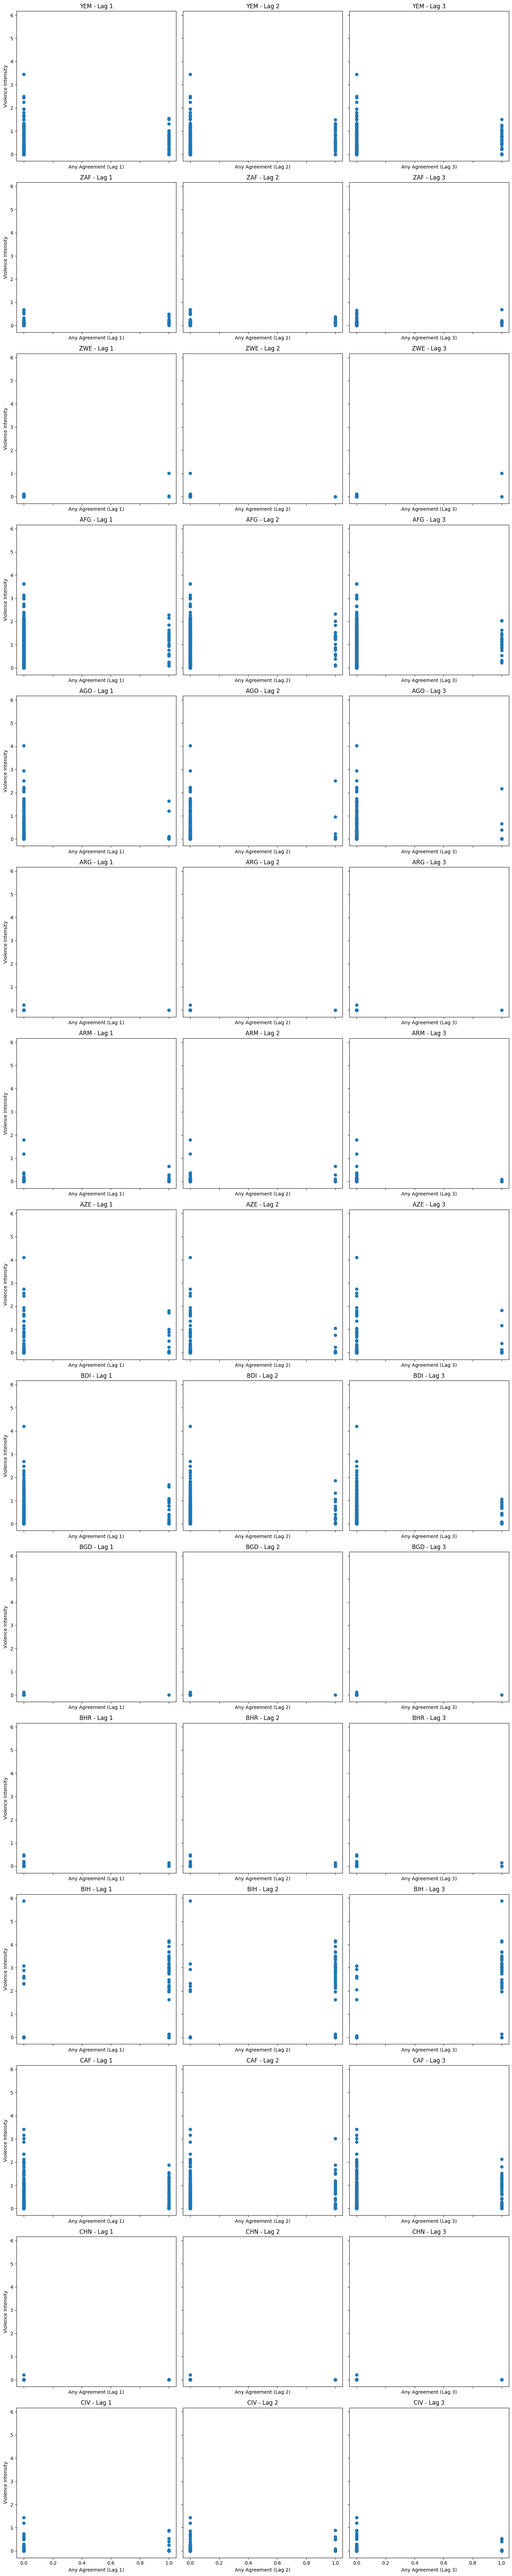

In [ ]:
countries_of_interest = ['YEM', 'ZAF', 'ZWE', 'AFG', 'AGO', 'ARG', 'ARM', 'AZE', 'BDI', 'BGD', 'BHR', 'BIH', 'CAF', 'CHN', 'CIV']

# Create subplots
fig, axes = plt.subplots(len(countries_of_interest), 3, figsize=(15, 5 * len(countries_of_interest)), sharex=True, sharey=True)

# Ensure axes is a 2D array
if len(countries_of_interest) == 1:
    axes = np.expand_dims(axes, axis=0)

for i, country in enumerate(countries_of_interest):
    country_data = df[df['isocode'] == country]

    axes[i, 0].scatter(country_data['pa_lag1'], country_data['violence_intensity'])
    axes[i, 0].set_title(f'{country} - Lag 1')
    axes[i, 0].set_xlabel('Any Agreement (Lag 1)')
    axes[i, 0].set_ylabel('Violence Intensity')

    axes[i, 1].scatter(country_data['pa_lag2'], country_data['violence_intensity'])
    axes[i, 1].set_title(f'{country} - Lag 2')
    axes[i, 1].set_xlabel('Any Agreement (Lag 2)')

    axes[i, 2].scatter(country_data['pa_lag3'], country_data['violence_intensity'])
    axes[i, 2].set_title(f'{country} - Lag 3')
    axes[i, 2].set_xlabel('Any Agreement (Lag 3)')

plt.tight_layout()
plt.show()


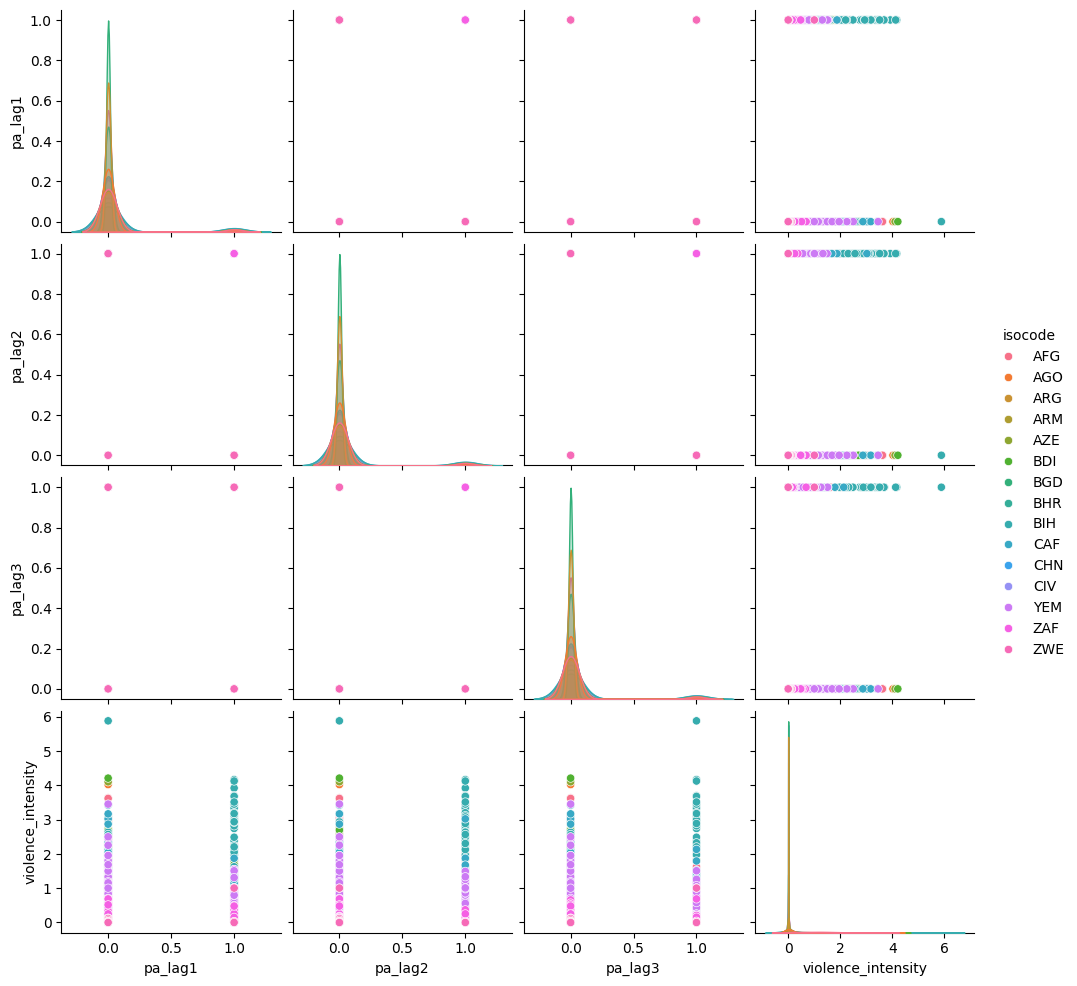

In [ ]:
# Select the relevant columns for the pairplot
pairplot_data = df[df['isocode'].isin(countries_of_interest)][['isocode', 'pa_lag1', 'pa_lag2', 'pa_lag3', 'violence_intensity']]

# Create the pairplot
sns.pairplot(pairplot_data, hue='isocode')
plt.show()

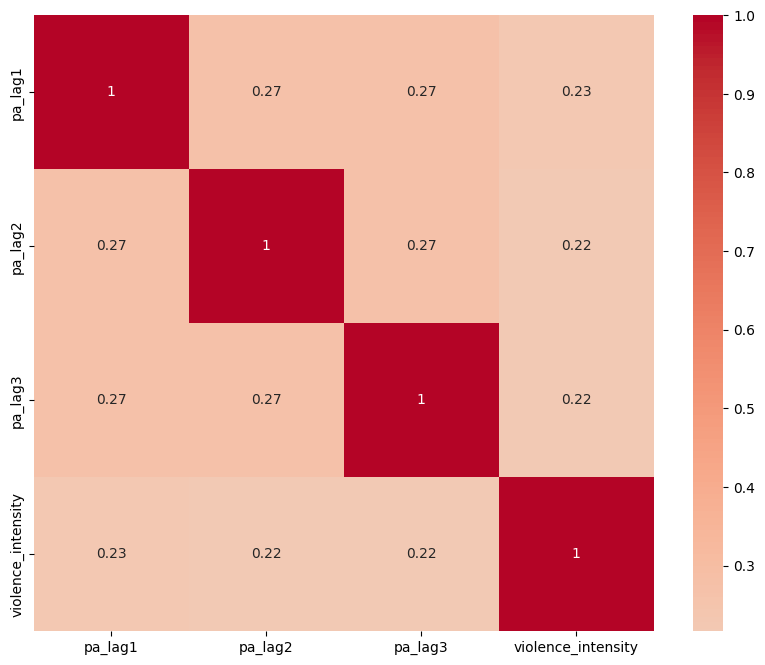

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df[df['isocode'].isin(countries_of_interest)][['pa_lag1', 'pa_lag2', 'pa_lag3', 'violence_intensity']].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

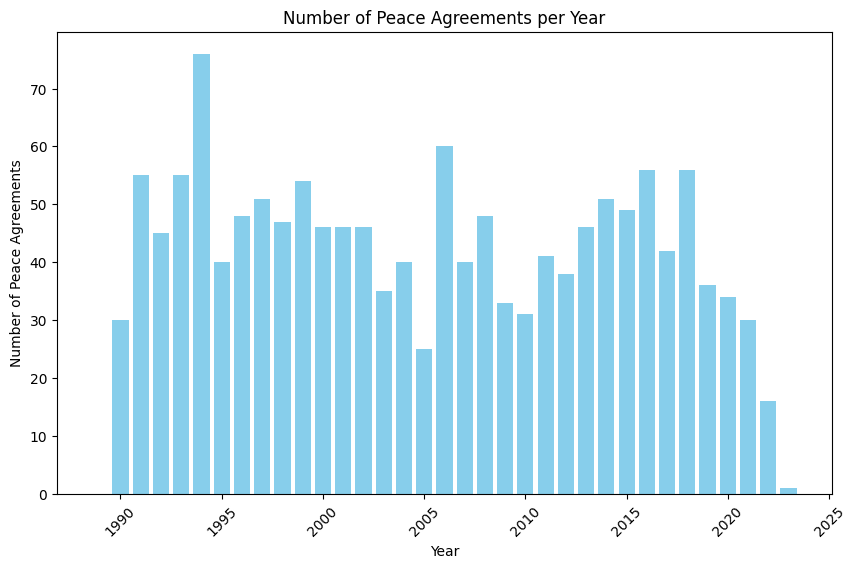

In [ ]:
# Group by year and count the number of peace agreements
peace_agreements_per_year = df.groupby('year')['pa_lag0'].sum().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(peace_agreements_per_year['year'], peace_agreements_per_year['pa_lag0'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Peace Agreements')
plt.title('Number of Peace Agreements per Year')
plt.xticks(rotation=45)
plt.show()


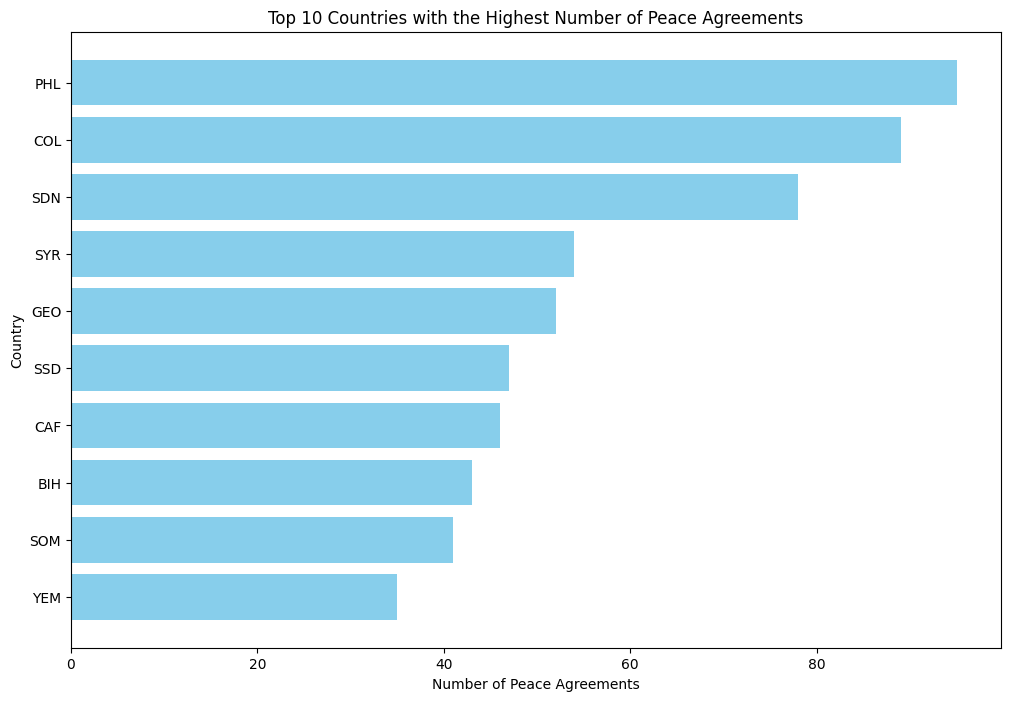

In [ ]:

# Group by isocode and count the number of peace agreements
peace_agreements_per_country = df.groupby('isocode')['pa_lag0'].sum().reset_index()

# Sort the countries by the number of peace agreements in descending order
peace_agreements_per_country = peace_agreements_per_country.sort_values(by='pa_lag0', ascending=False)

# Plot the top 10 countries with the highest number of peace agreements
top_countries = peace_agreements_per_country.head(10)

plt.figure(figsize=(12, 8))
plt.barh(top_countries['isocode'], top_countries['pa_lag0'], color='skyblue')
plt.xlabel('Number of Peace Agreements')
plt.ylabel('Country')
plt.title('Top 10 Countries with the Highest Number of Peace Agreements')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest values at the top
plt.show()


In [ ]:
# Step 1: Identify countries with at least one peace agreement
countries_with_agreements = df[df['pa_lag0'] > 0]['isocode'].unique()

# Step 2: Calculate the total number of unique countries
total_countries = df['isocode'].nunique()

# Step 3: Calculate the percentage of countries with peace agreements
percentage_with_agreements = (len(countries_with_agreements) / total_countries) * 100

print(f"Percentage of countries with peace agreements: {percentage_with_agreements:.2f}%")

Percentage of countries with peace agreements: 46.43%


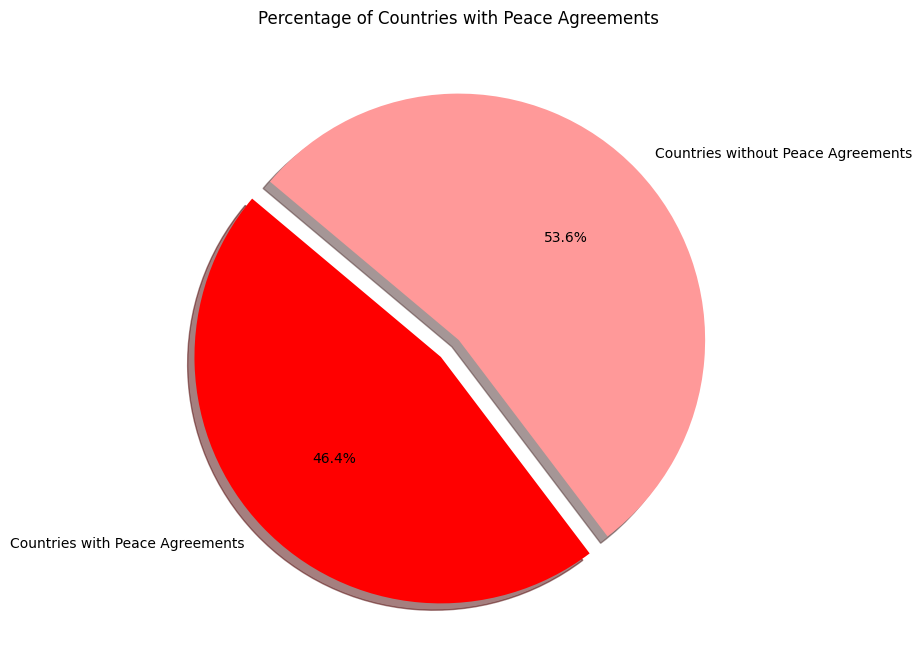

In [ ]:
# Data for the pie chart
labels = ['Countries with Peace Agreements', 'Countries without Peace Agreements']
sizes = [len(countries_with_agreements), total_countries - len(countries_with_agreements)]
colors = ['red','#ff9999']
explode = (0.1, 0)  # explode the 1st slice

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of Countries with Peace Agreements')
plt.show()

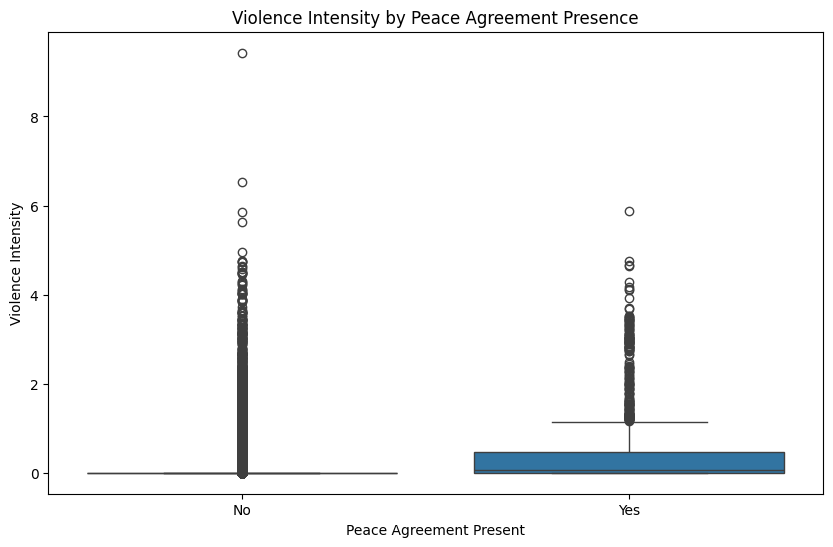

In [ ]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='pa_lag0', y='violence_intensity', data=df)
plt.xlabel('Peace Agreement Present')
plt.ylabel('Violence Intensity')
plt.title('Violence Intensity by Peace Agreement Presence')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

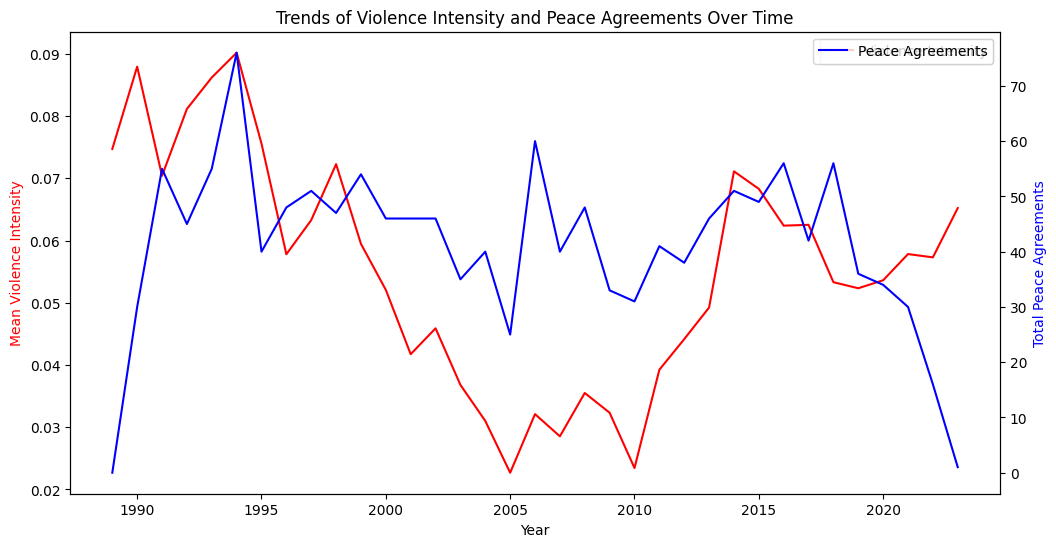

In [ ]:
### Time Series Plot
yearly_data = df.groupby('year').agg({'violence_intensity': 'mean', 'pa_lag0': 'sum'}).reset_index()

# Time series plot
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
sns.lineplot(x='year', y='violence_intensity', data=yearly_data, ax=ax1, label='Violence Intensity', color='r')
sns.lineplot(x='year', y='pa_lag0', data=yearly_data, ax=ax2, label='Peace Agreements', color='b')

ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Violence Intensity', color='r')
ax2.set_ylabel('Total Peace Agreements', color='b')
ax1.set_title('Trends of Violence Intensity and Peace Agreements Over Time')
plt.show()

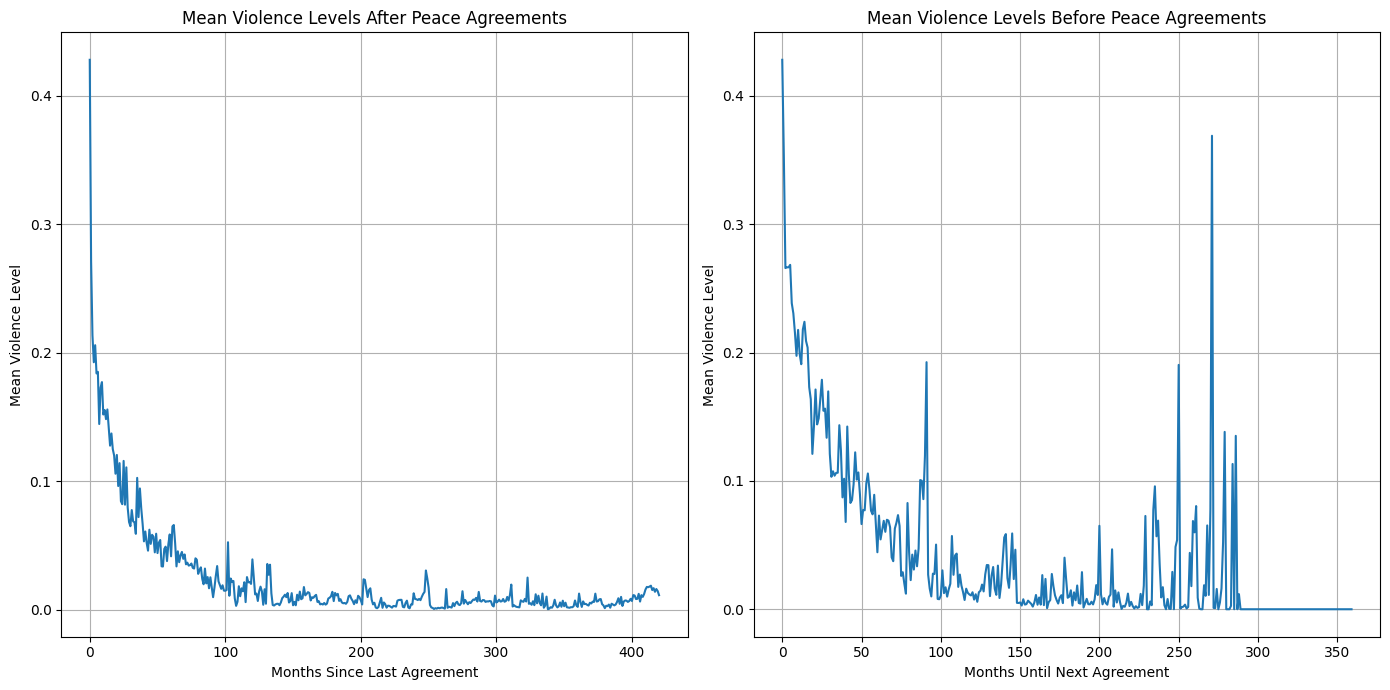

In [ ]:
# Calculate mean violence levels
mean_violence_since = df.groupby('since_agreement')['violence_intensity'].mean().reset_index()
mean_violence_until = df.groupby('until_agreement')['violence_intensity'].mean().reset_index()

# Create plots
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.lineplot(x='since_agreement', y='violence_intensity', data=mean_violence_since)
plt.title('Mean Violence Levels After Peace Agreements')
plt.xlabel('Months Since Last Agreement')
plt.ylabel('Mean Violence Level')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(x='until_agreement', y='violence_intensity', data=mean_violence_until)
plt.title('Mean Violence Levels Before Peace Agreements')
plt.xlabel('Months Until Next Agreement')
plt.ylabel('Mean Violence Level')
plt.grid(True)

plt.tight_layout()
plt.show()

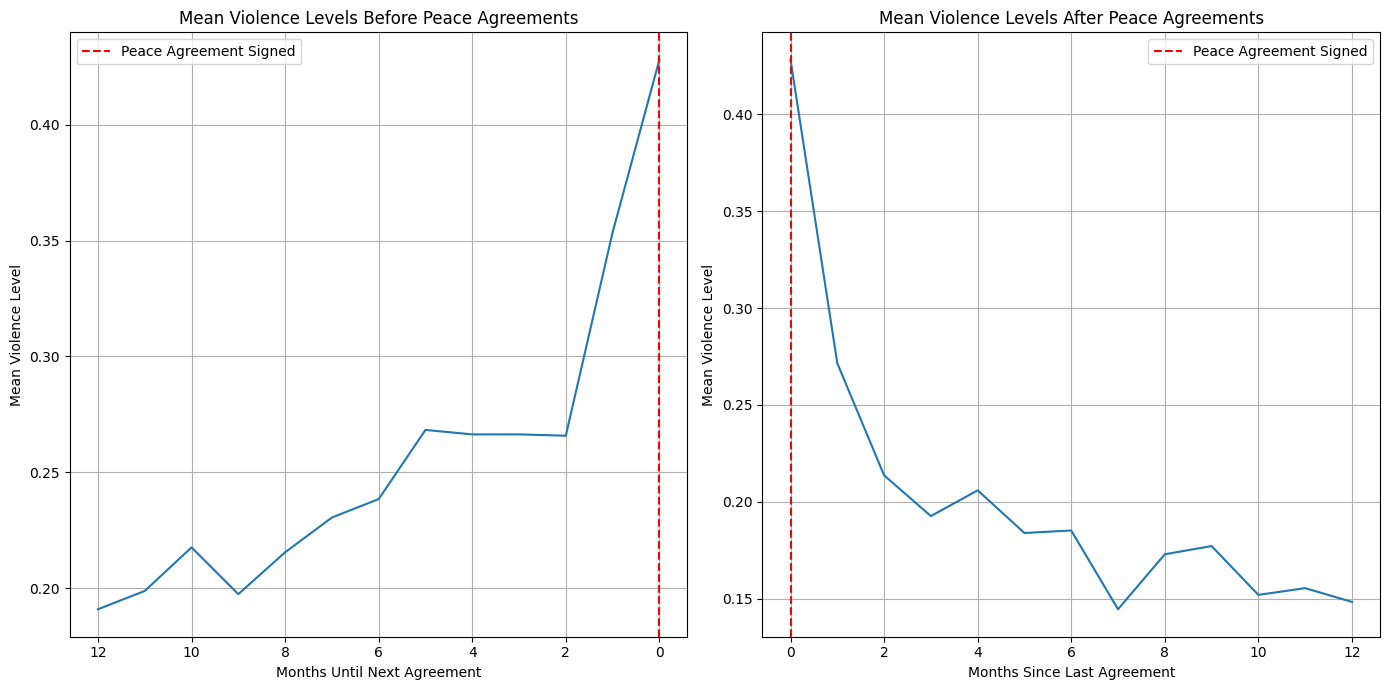

In [ ]:
# Filter data to include only 12 months prior and 12 months after the agreements
df_until = df[df['until_agreement'] <= 12]
df_since = df[df['since_agreement'] <= 12]

# Calculate mean violence levels for the filtered data
mean_violence_until = df_until.groupby('until_agreement')['violence_intensity'].mean().reset_index()
mean_violence_since = df_since.groupby('since_agreement')['violence_intensity'].mean().reset_index()

# Create plots
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.lineplot(x='until_agreement', y='violence_intensity', data=mean_violence_until)
plt.axvline(x=0, color='r', linestyle='--', label='Peace Agreement Signed')
plt.gca().invert_xaxis()
plt.title('Mean Violence Levels Before Peace Agreements')
plt.xlabel('Months Until Next Agreement')
plt.ylabel('Mean Violence Level')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(x='since_agreement', y='violence_intensity', data=mean_violence_since)
plt.axvline(x=0, color='r', linestyle='--', label='Peace Agreement Signed')
plt.title('Mean Violence Levels After Peace Agreements')
plt.xlabel('Months Since Last Agreement')
plt.ylabel('Mean Violence Level')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## <a id='part3'>Part 3: Fixed Effects</a>

We use one-hot encoding for each country, introducing “dummy” variables that represent country-specific fixed effects. This enabled us to account for each country's unique characteristics without directly observing them, reducing bias in our causal estimates and allowing the model to focus on the effects of peace agreements themselves.

In [ ]:
#let's buld a df w/ only our X variables to turn into a list
X_var = df.drop(columns=['isocode', 'period', 'year', 'month', 'violence_intensity', 'ons_anyviolence_6', 'ons_armedconf_6', 'ons_civilwar_6', 'num_agreements', 'agreement_id', 'since_agreement',
 'until_agreement', 'uncertainty_index',  'democracy0', 'until_armedconf', 'democracy1', 'democracy2', 'democracy3',
 'democracy4', 'democracy5', 'best', 'ged_best_ns', 'ged_best_os', 'ged_best_sb', 'anyviolence',
 'armedconf', 'civilwar', 'past6', 'past12', 'past60', 'past120', 'anyviolence_dp', 'armedconf_dp','civilwar_dp', 'ged_best_ns_dp', 'ged_best_os_dp', 'ged_best_sb_dp',
 'ons_ged_best_ns1', 'ons_ged_best_ns3', 'ons_ged_best_ns12', 'ons_ged_best_os1', 'ons_ged_best_os12', 'ons_ged_best_sb1', 'ons_ged_best_sb3',
 'ons_ged_best_sb12', 'anyviolence1', 'armedconf1', 'civilwar1', 'contig_anyviolence', 'pa_lag0', 'pa_lag1', 'pa_lag2', 'pa_lag3', 'pa_lag4', 'pa_lag5', 'pa_lag6', 'pa_lag7', 'pa_lag8', 'pa_lag9', 'pa_lag10', 'pa_lag11', 'pa_lag12'])

cov_list = X_var.columns.to_list()

#next we build a df with all columns needed to run DML
train_data = df.drop(columns=['year', 'month',  'ons_anyviolence_6', 'ons_armedconf_6', 'ons_civilwar_6', 'num_agreements', 'agreement_id', 'since_agreement',
 'until_agreement', 'uncertainty_index',  'democracy0', 'until_armedconf', 'democracy1', 'democracy2', 'democracy3',
 'democracy4', 'democracy5', 'best', 'ged_best_ns', 'ged_best_os', 'ged_best_sb', 'anyviolence',
 'armedconf', 'civilwar', 'past6', 'past12', 'past60', 'past120', 'anyviolence_dp', 'armedconf_dp','civilwar_dp', 'ged_best_ns_dp', 'ged_best_os_dp', 'ged_best_sb_dp',
 'ons_ged_best_ns1', 'ons_ged_best_ns3', 'ons_ged_best_ns12', 'ons_ged_best_os1', 'ons_ged_best_os12', 'ons_ged_best_sb1', 'ons_ged_best_sb3',
 'ons_ged_best_sb12', 'anyviolence1', 'armedconf1', 'civilwar1', 'contig_anyviolence', ])

train_data[cov_list] = train_data[cov_list].fillna(0) #we fill the missing X values with 0s
train_data_clean = train_data.dropna().reset_index(drop=True) #then drop everything else that is missing

train_data_clean.head()

,tokens_lag0,obs_lag0,sentiment_words_lag0,uncertainty_lag0,ste_theta0_lag0,ste_theta1_lag0,ste_theta2_lag0,ste_theta3_lag0,ste_theta4_lag0,ste_theta5_lag0,...,populationwb_lag4,populationwb_lag5,populationwb_lag6,populationwb_lag7,populationwb_lag8,populationwb_lag9,populationwb_lag10,populationwb_lag11,populationwb_lag12,violence_intensity
0,10321.0,95.0,226.69230,1.0,0.084435,0.063614,0.076610,0.028937,0.023861,0.023477,...,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,0.183498
1,7444.0,40.0,385.63420,1.0,0.190768,0.057778,0.094718,0.024209,0.021914,0.027381,...,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,0.361201
2,10772.0,83.0,104.41520,1.0,0.073899,0.048422,0.056478,0.046712,0.003981,0.052854,...,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,0.788649
3,4816.0,63.0,92.11496,0.0,0.080852,0.036736,0.053462,0.022228,0.013414,0.026407,...,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,1.597292
4,8132.0,64.0,356.23420,1.0,0.167025,0.036029,0.056788,0.084723,0.007625,0.051279,...,12412308.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,11868877.0,0.062460


In [ ]:
one_hot_encoded = pd.get_dummies(train_data_clean['isocode'], prefix='isocode', drop_first=True)

#concatenate with Original DataFrame
train_data_encoded = pd.concat([train_data_clean, one_hot_encoded], axis=1)

one_hot_encoded_list = one_hot_encoded.columns.to_list()

In [ ]:
train_data_encoded.to_csv(path_out_ + 'data_ohe.csv', index=False)

In [ ]:
train_data_encoded = pd.read_csv(path_out_ + 'data_ohe.csv')

## <a id='part4'>Part 4: Grid Search: Hyperparameters </a>


Having a well-performing model is pretty essential before running the DML model. If the metrics are off, the DML estimates will be off, so here we perform grid search to find the best parameters for $g(X)$.

In [ ]:
#list of base covariates
base_covariates = [
    'populationwb', 'since_anyviolence', 'since_armedconf', 'since_civilwar',
    'tokens', 'obs', 'sentiment_words', 'uncertainty', 'ste_theta0', 'ste_theta1',
    'ste_theta2', 'ste_theta3', 'ste_theta4', 'ste_theta5', 'ste_theta6', 'ste_theta7',
    'ste_theta8', 'ste_theta9', 'ste_theta10', 'ste_theta11', 'ste_theta12',
    'ste_theta13', 'ste_theta14', 'ste_theta0_stock', 'ste_theta1_stock',
    'ste_theta2_stock', 'ste_theta3_stock', 'ste_theta4_stock', 'ste_theta5_stock',
    'ste_theta6_stock', 'ste_theta7_stock', 'ste_theta8_stock', 'ste_theta9_stock',
    'ste_theta10_stock', 'ste_theta11_stock', 'ste_theta12_stock', 'ste_theta13_stock',
    'ste_theta14_stock', 'sentiment_stock'
]

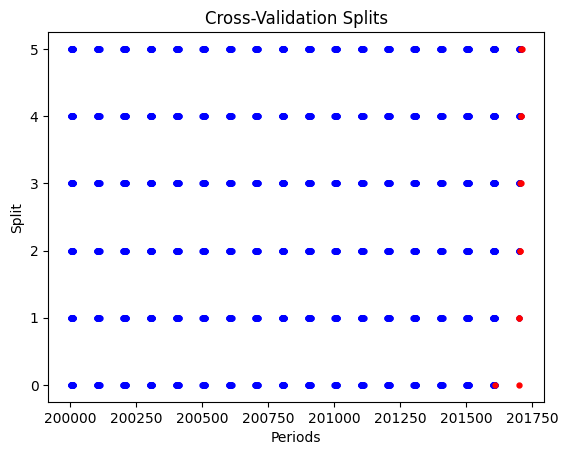

In [ ]:
from panelsplit import PanelSplit

validation_data = train_data_encoded[(train_data_encoded['period'] > 200001) & (train_data_encoded['period'] < 201712)] #filter data

X_base = [] #set dict for og covariates

for lag in range(0, 1):
    covariates = [f'{cov}_lag{lag}' for cov in base_covariates]
    X_base.extend(covariates)
X_base.extend(one_hot_encoded_list)

#set variables
treatment = f'pa_lag0'
outcome = 'violence_intensity'

T = validation_data[treatment]
Y = validation_data[outcome]
X = validation_data[X_base]


periods = validation_data['period']
unique_sorted_periods = pd.Series(periods.unique()).sort_values()
panel_split = PanelSplit(
    periods,
    unique_periods=unique_sorted_periods,
    n_splits=6,  # Adjust the number of splits as needed
    gap=0,
    test_size=2,
    plot=True
)

In [ ]:
param_grid = {
    'n_estimators': [100, 120],
    'max_depth': [9],
    'min_samples_leaf': [5]
}

param_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=panel_split,
    n_jobs=-1,  # Use all available processors
    verbose=3,
)


In [ ]:
with joblib.parallel_backend('loky'):
  param_search.fit(X, Y)

best_params = param_search.best_params_
print(f"Best parameters for outcome model: {param_search.best_params_}")
print(f"Best cross-validation score for outcome model: {param_search.best_score_}")

Fitting 6 folds for each of 2 candidates, totalling 12 fits
Best parameters for outcome model: {'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 100}
Best cross-validation score for outcome model: -0.0038018149011931394


In [ ]:
rmse = np.sqrt(-param_search.best_score_)
print(f"RMSE: {rmse}")

#average of outcome
print(f"Average outcome: {Y.mean()}")

We perform gridsearch for $m(X)$

In [ ]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [6, 7],
    'min_samples_leaf':[6, 7]
}

param_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    scoring='roc_auc',
    cv=panel_split,
    n_jobs=-1,
    verbose=3,
)

param_search.fit(X, T)

best_params = param_search.best_params_
print(f"Best parameters for treatment model: {param_search.best_params_}")
print(f"Best cross-validation score for treatment model: {param_search.best_score_}")

Fitting 6 folds for each of 4 candidates, totalling 24 fits
Best parameters for treatment model: {'max_depth': 7, 'min_samples_leaf': 7, 'n_estimators': 100}
Best cross-validation score for treatment model: 0.9646797692555421


## <a id='part5'>Part 5: Train and Fit DML</a>



In [ ]:
def dml_process_treatment_t(X_base, X_lagged, Y, T, model_y, model_t, panel_split, lag):

    # Combine X_base (lag0 features) with lagged features in X_lagged for outcome model only
    X_outcome = pd.concat([X_base, X_lagged], axis=1)

    # Initialize arrays to hold residuals
    y_residuals = np.zeros_like(Y, dtype=float)
    T_residuals = np.zeros_like(T, dtype=float)
    fold_theta_estimates = []

    # Initialize lists to store metrics
    neg_mse_list = []
    auc_list = []

    # Cross-fitting using PanelSplit
    for i, (train_indices, test_indices) in enumerate(panel_split.split()):
        # For the treatment model, only use the lagged covariates (specific to the given lag)
        X_train_t, X_test_t = X_lagged.iloc[train_indices], X_lagged.iloc[test_indices]

        # For the outcome model, use both base (lag0) and lagged covariates
        X_outcome_train, X_outcome_test = X_outcome.iloc[train_indices], X_outcome.iloc[test_indices]
        Y_train, Y_test = Y.iloc[train_indices], Y.iloc[test_indices]
        T_train, T_test = T.iloc[train_indices], T.iloc[test_indices]

        # Fit models and calculate residuals as before
        model_y.fit(X_outcome_train, Y_train)
        g_predictions = model_y.predict(X_outcome_test)
        neg_mse = -mean_squared_error(Y_test, g_predictions)
        neg_mse_list.append(neg_mse)

        model_t.fit(X_train_t, T_train)
        m_predictions = model_t.predict_proba(X_test_t)
        auc = roc_auc_score(T_test, m_predictions[:, 1])
        auc_list.append(auc)

        # Compute residuals
        y_residuals[test_indices] = Y_test - g_predictions
        T_residuals[test_indices] = T_test - m_predictions[:, 1]

        # Estimate theta
        fold_theta = np.sum(T_residuals[test_indices] * y_residuals[test_indices]) / np.sum(T_residuals[test_indices] ** 2)
        fold_theta_estimates.append(fold_theta)

    # Average theta, standard error, and confidence intervals
    theta_hat = np.mean(fold_theta_estimates)
    se_theta = np.std(fold_theta_estimates) / np.sqrt(len(fold_theta_estimates))
    ci_lower = theta_hat - 1.96 * se_theta
    ci_upper = theta_hat + 1.96 * se_theta

    print(f'Lag {lag} results - Theta: {theta_hat}, CI: ({ci_lower}, {ci_upper})')

    return {
        'theta': theta_hat,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'neg_mse_avg': np.mean(neg_mse_list),
        'auc_avg': np.mean(auc_list)
    }

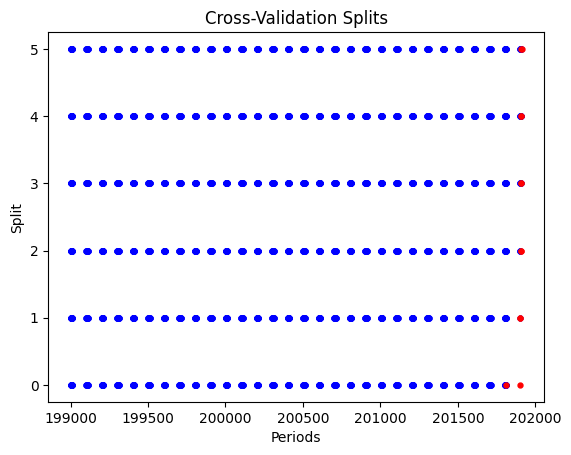

In [ ]:
model_y = RandomForestRegressor(n_estimators=120, max_depth=9, min_samples_leaf=5)
model_t = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=7)


train_data = train_data_encoded[train_data_encoded['period'] < 201912]
T = train_data[f'pa_lag0']
Y = train_data['violence_intensity']

all_covariates = []

for lag in range(0, 13):
    lagged_covariates = [f'{cov}_lag{lag}' for cov in base_covariates]
    all_covariates.extend(lagged_covariates)
all_covariates.extend(one_hot_encoded_list)
X = train_data[all_covariates]

X_base = train_data[[
    'populationwb_lag0', 'since_anyviolence_lag0', 'since_armedconf_lag0', 'since_civilwar_lag0',
    'tokens_lag0', 'obs_lag0', 'sentiment_words_lag0', 'uncertainty_lag0', 'ste_theta0_lag0', 'ste_theta1_lag0',
    'ste_theta2_lag0', 'ste_theta3_lag0', 'ste_theta4_lag0', 'ste_theta5_lag0', 'ste_theta6_lag0', 'ste_theta7_lag0',
    'ste_theta8_lag0', 'ste_theta9_lag0', 'ste_theta10_lag0', 'ste_theta11_lag0', 'ste_theta12_lag0',
    'ste_theta13_lag0', 'ste_theta14_lag0', 'ste_theta0_stock_lag0', 'ste_theta1_stock_lag0',
    'ste_theta2_stock_lag0', 'ste_theta3_stock_lag0', 'ste_theta4_stock_lag0', 'ste_theta5_stock_lag0',
    'ste_theta6_stock_lag0', 'ste_theta7_stock_lag0', 'ste_theta8_stock_lag0', 'ste_theta9_stock_lag0',
    'ste_theta10_stock_lag0', 'ste_theta11_stock_lag0', 'ste_theta12_stock_lag0', 'ste_theta13_stock_lag0',
    'ste_theta14_stock_lag0', 'sentiment_stock_lag0'
]]


periods = train_data['period']
unique_sorted_periods = pd.Series(periods.unique()).sort_values()

panel_split = PanelSplit(
    periods,
    unique_periods=unique_sorted_periods,
    n_splits=6,
    gap=0,
    test_size=2,
    plot=True
)

In [ ]:
# Example of iterating over splits in PanelSplit
for fold, (train_indices, test_indices) in enumerate(panel_split.split()):
    train_fold = train_data.iloc[train_indices]
    test_fold = train_data.iloc[test_indices]

    print(f"Fold {fold+1} - Training Set Target Distribution:")
    print(train_fold['pa_lag6'].value_counts(normalize=True))

    print(f"Fold {fold+1} - Test Set Target Distribution:")
    print(test_fold['pa_lag6'].value_counts(normalize=True))
    print("-" * 40)

Fold 1 - Training Set Target Distribution:
pa_lag6
0.0    0.980758
1.0    0.019242
Name: proportion, dtype: float64
Fold 1 - Test Set Target Distribution:
pa_lag6
0.0    0.969388
1.0    0.030612
Name: proportion, dtype: float64
----------------------------------------
Fold 2 - Training Set Target Distribution:
pa_lag6
0.0    0.980691
1.0    0.019309
Name: proportion, dtype: float64
Fold 2 - Test Set Target Distribution:
pa_lag6
0.0    0.969388
1.0    0.030612
Name: proportion, dtype: float64
----------------------------------------
Fold 3 - Training Set Target Distribution:
pa_lag6
0.0    0.980625
1.0    0.019375
Name: proportion, dtype: float64
Fold 3 - Test Set Target Distribution:
pa_lag6
0.0    0.982143
1.0    0.017857
Name: proportion, dtype: float64
----------------------------------------
Fold 4 - Training Set Target Distribution:
pa_lag6
0.0    0.980634
1.0    0.019366
Name: proportion, dtype: float64
Fold 4 - Test Set Target Distribution:
pa_lag6
0.0    0.977041
1.0    0.02295

In [ ]:
#dict to store results for each lag
lag_results = {}

# Iterate over each lag in the specified range
for lag in range(0, 13):
    # Select only the covariates with the current lag suffix
    current_lagged_covariates = [f'{cov}_lag{lag}' for cov in base_covariates] + one_hot_encoded_list
    X_lagged = train_data[current_lagged_covariates]  # Filter only current lag columns

    # Update T to use the lag-specific treatment column
    T = train_data[f'pa_lag{lag}']

    # Call the function and store the result
    result = dml_process_treatment_t(X_base, X_lagged, Y, T, model_y, model_t, panel_split, lag)
    # Store the result in the dictionary with the lag as the key
    lag_results[lag] = result
    print(f"Lag {lag} done!")
    print(result)

Lag 0 results - Theta: -0.0346349477964568, CI: (-0.1217969776607257, 0.05252708206781209)
Lag 0 done!
{'theta': -0.0346349477964568, 'ci_lower': -0.1217969776607257, 'ci_upper': 0.05252708206781209, 'neg_mse_avg': -0.003822982168463956, 'auc_avg': 0.966940613184572}
Lag 1 results - Theta: -0.05106659166420041, CI: (-0.09805726716402838, -0.004075916164372438)
Lag 1 done!
{'theta': -0.05106659166420041, 'ci_lower': -0.09805726716402838, 'ci_upper': -0.004075916164372438, 'neg_mse_avg': -0.00394926415896337, 'auc_avg': 0.9651805568229882}
Lag 2 results - Theta: -0.07354763046729478, CI: (-0.14179754257632632, -0.0052977183582632315)
Lag 2 done!
{'theta': -0.07354763046729478, 'ci_lower': -0.14179754257632632, 'ci_upper': -0.0052977183582632315, 'neg_mse_avg': -0.0037174476427650253, 'auc_avg': 0.9630564842929704}
Lag 3 results - Theta: -0.0657537203194512, CI: (-0.12831536319914388, -0.003192077439758509)
Lag 3 done!
{'theta': -0.0657537203194512, 'ci_lower': -0.12831536319914388, 'ci_u

In [ ]:
#save lag_results as pickle so we don't lose anything (the code can take hours to run even on A100 GPU)
with open(path_in_ + 'lag_results.pkl', 'wb') as f:
    pickle.dump(lag_results, f)

In [ ]:
# Load the dictionary from the file
with open(path_in_ + 'lag_results.pkl', 'rb') as file:
    lag_results = pickle.load(file)

print(lag_results)

{0: {'theta': -0.0346349477964568, 'ci_lower': -0.1217969776607257, 'ci_upper': 0.05252708206781209, 'neg_mse_avg': -0.003822982168463956, 'auc_avg': 0.966940613184572}, 1: {'theta': -0.05106659166420041, 'ci_lower': -0.09805726716402838, 'ci_upper': -0.004075916164372438, 'neg_mse_avg': -0.00394926415896337, 'auc_avg': 0.9651805568229882}, 2: {'theta': -0.07354763046729478, 'ci_lower': -0.14179754257632632, 'ci_upper': -0.0052977183582632315, 'neg_mse_avg': -0.0037174476427650253, 'auc_avg': 0.9630564842929704}, 3: {'theta': -0.0657537203194512, 'ci_lower': -0.12831536319914388, 'ci_upper': -0.003192077439758509, 'neg_mse_avg': -0.004018275678552379, 'auc_avg': 0.9598997236352256}, 4: {'theta': -0.06444321681394505, 'ci_lower': -0.10522744018365249, 'ci_upper': -0.0236589934442376, 'neg_mse_avg': -0.003842463654762672, 'auc_avg': 0.9641225480643275}, 5: {'theta': -0.03855393463358625, 'ci_lower': -0.07641266135862085, 'ci_upper': -0.0006952079085516469, 'neg_mse_avg': -0.0036989063440

In [ ]:
#convert lag_results to df
lag_results_df = pd.DataFrame(lag_results).T
lag_results_df.head()

,theta,ci_lower,ci_upper,neg_mse_avg,auc_avg
0,-0.034635,-0.121797,0.052527,-0.003823,0.966941
1,-0.051067,-0.098057,-0.004076,-0.003949,0.965181
2,-0.073548,-0.141798,-0.005298,-0.003717,0.963056
3,-0.065754,-0.128315,-0.003192,-0.004018,0.959900
4,-0.064443,-0.105227,-0.023659,-0.003842,0.964123


## <a id='part6'>Part 6: Sensitivity Analysis with Placebos</a>

In [ ]:
#set index to col named 'lag'
lag_results_df.reset_index(inplace=True)
lag_results_df.rename(columns={'index': 'lag'}, inplace=True)
lag_results_df.head()

,lag,theta,ci_lower,ci_upper,neg_mse_avg,auc_avg
0,0,-0.034635,-0.121797,0.052527,-0.003823,0.966941
1,1,-0.051067,-0.098057,-0.004076,-0.003949,0.965181
2,2,-0.073548,-0.141798,-0.005298,-0.003717,0.963056
3,3,-0.065754,-0.128315,-0.003192,-0.004018,0.959900
4,4,-0.064443,-0.105227,-0.023659,-0.003842,0.964123


In [ ]:
def sensitivity_analysis_test(df, learner='RandomForest'):
  df = df.sort_values('lag')
  lags = df['lag']
  effects = df['theta']
  conf_lower = df['ci_lower']
  conf_upper = df['ci_upper']

  # Plotting the effects and confidence intervals
  plt.figure(figsize=(10, 6))
  plt.plot(lags, effects, marker='o', label='Estimated Effect')
  plt.fill_between(lags, conf_lower, conf_upper, color='b', alpha=0.2, label='95% CI')
  plt.axhline(0, color='gray', linestyle='--')
  plt.xlabel('Lag Length')
  plt.ylabel('Estimated Treatment Effect')
  plt.title(f'Lag Length Sensitivity Analysis - {learner}')
  plt.legend()
  plt.grid(True)
  plt.show()


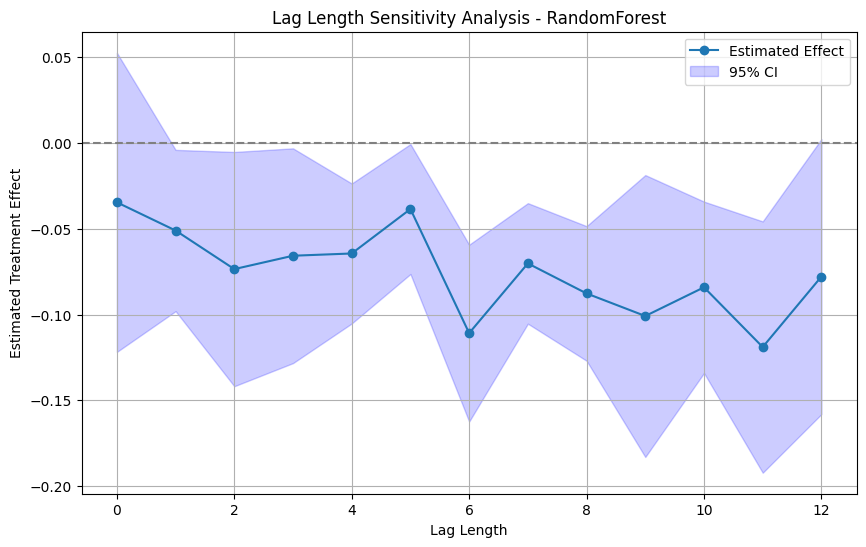

In [ ]:
sensitivity_analysis_test(lag_results_df)

In [ ]:
df_phased = pd.read_csv(path_out_ + 'data_ohe.csv')

df_phased.head()

,tokens_lag0,obs_lag0,sentiment_words_lag0,uncertainty_lag0,ste_theta0_lag0,ste_theta1_lag0,ste_theta2_lag0,ste_theta3_lag0,ste_theta4_lag0,ste_theta5_lag0,...,isocode_VCT,isocode_VEN,isocode_VNM,isocode_VUT,isocode_WSM,isocode_XKX,isocode_YEM,isocode_ZAF,isocode_ZMB,isocode_ZWE
0,10321.0,95.0,226.69230,1.0,0.084435,0.063614,0.076610,0.028937,0.023861,0.023477,...,False,False,False,False,False,False,False,False,False,False
1,7444.0,40.0,385.63420,1.0,0.190768,0.057778,0.094718,0.024209,0.021914,0.027381,...,False,False,False,False,False,False,False,False,False,False
2,10772.0,83.0,104.41520,1.0,0.073899,0.048422,0.056478,0.046712,0.003981,0.052854,...,False,False,False,False,False,False,False,False,False,False
3,4816.0,63.0,92.11496,0.0,0.080852,0.036736,0.053462,0.022228,0.013414,0.026407,...,False,False,False,False,False,False,False,False,False,False
4,8132.0,64.0,356.23420,1.0,0.167025,0.036029,0.056788,0.084723,0.007625,0.051279,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#shift treatment variable backwards for placebo test
for i in range(1, 13):
    df_phased[f'pa_placebo_lag{i}'] = df_phased.groupby('isocode')['pa_lag0'].shift(-i)

df_phased[[f'pa_placebo_lag{i}' for i in range(1, 13)]] = df_phased[[f'pa_placebo_lag{i}' for i in range(1, 13)]].fillna(0)

print(df_phased[['isocode', 'period', 'pa_lag0'] + [f'pa_placebo_lag{i}' for i in range(1, 13)]].head())


  isocode  period  pa_lag0  pa_placebo_lag1  pa_placebo_lag2  pa_placebo_lag3  \
0     AFG  199001      0.0              0.0              0.0              0.0   
1     AFG  199002      0.0              0.0              0.0              0.0   
2     AFG  199003      0.0              0.0              0.0              0.0   
3     AFG  199004      0.0              0.0              0.0              0.0   
4     AFG  199005      0.0              0.0              0.0              0.0   

   pa_placebo_lag4  pa_placebo_lag5  pa_placebo_lag6  pa_placebo_lag7  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   pa_placebo_lag8  pa_placebo_lag9  pa_placebo_lag10  pa_placebo_lag11  \

In [ ]:
#create lags for the covariates
df_phased.sort_values(by=['isocode', 'period'], inplace=True)

covariates = [
    'populationwb_lag0', 'since_anyviolence_lag0', 'since_armedconf_lag0', 'since_civilwar_lag0',
    'tokens_lag0', 'obs_lag0', 'sentiment_words_lag0', 'uncertainty_lag0', 'ste_theta0_lag0', 'ste_theta1_lag0',
    'ste_theta2_lag0', 'ste_theta3_lag0', 'ste_theta4_lag0', 'ste_theta5_lag0', 'ste_theta6_lag0', 'ste_theta7_lag0',
    'ste_theta8_lag0', 'ste_theta9_lag0', 'ste_theta10_lag0', 'ste_theta11_lag0', 'ste_theta12_lag0',
    'ste_theta13_lag0', 'ste_theta14_lag0', 'ste_theta0_stock_lag0', 'ste_theta1_stock_lag0',
    'ste_theta2_stock_lag0', 'ste_theta3_stock_lag0', 'ste_theta4_stock_lag0', 'ste_theta5_stock_lag0',
    'ste_theta6_stock_lag0', 'ste_theta7_stock_lag0', 'ste_theta8_stock_lag0', 'ste_theta9_stock_lag0',
    'ste_theta10_stock_lag0', 'ste_theta11_stock_lag0', 'ste_theta12_stock_lag0', 'ste_theta13_stock_lag0',
    'ste_theta14_stock_lag0', 'sentiment_stock_lag0'
]

df_phased[covariates] = df_phased[covariates].fillna(0)
number_of_lags = 12
new_columns = {}

for cov in covariates:
    for lag in range(1, number_of_lags + 1):
        new_columns[f'{cov}_placebo_lag{lag}'] = df_phased.groupby('isocode')[cov].shift(-lag)

df_phased = pd.concat([df_phased, pd.DataFrame(new_columns, index=df_phased.index)], axis=1)
df_phased[list(new_columns.keys())] = df_phased[list(new_columns.keys())].fillna(0)

In [ ]:
df_phased.head()

,tokens_lag0,obs_lag0,sentiment_words_lag0,uncertainty_lag0,ste_theta0_lag0,ste_theta1_lag0,ste_theta2_lag0,ste_theta3_lag0,ste_theta4_lag0,ste_theta5_lag0,...,sentiment_stock_lag0_placebo_lag3,sentiment_stock_lag0_placebo_lag4,sentiment_stock_lag0_placebo_lag5,sentiment_stock_lag0_placebo_lag6,sentiment_stock_lag0_placebo_lag7,sentiment_stock_lag0_placebo_lag8,sentiment_stock_lag0_placebo_lag9,sentiment_stock_lag0_placebo_lag10,sentiment_stock_lag0_placebo_lag11,sentiment_stock_lag0_placebo_lag12
0,10321.0,95.0,226.69230,1.0,0.084435,0.063614,0.076610,0.028937,0.023861,0.023477,...,0.001784,0.007204,0.004065,0.004672,0.006771,0.001544,0.006664,0.002458,0.005395,0.003476
1,7444.0,40.0,385.63420,1.0,0.190768,0.057778,0.094718,0.024209,0.021914,0.027381,...,0.007204,0.004065,0.004672,0.006771,0.001544,0.006664,0.002458,0.005395,0.003476,0.005708
2,10772.0,83.0,104.41520,1.0,0.073899,0.048422,0.056478,0.046712,0.003981,0.052854,...,0.004065,0.004672,0.006771,0.001544,0.006664,0.002458,0.005395,0.003476,0.005708,0.010581
3,4816.0,63.0,92.11496,0.0,0.080852,0.036736,0.053462,0.022228,0.013414,0.026407,...,0.004672,0.006771,0.001544,0.006664,0.002458,0.005395,0.003476,0.005708,0.010581,0.006375
4,8132.0,64.0,356.23420,1.0,0.167025,0.036029,0.056788,0.084723,0.007625,0.051279,...,0.006771,0.001544,0.006664,0.002458,0.005395,0.003476,0.005708,0.010581,0.006375,0.002035


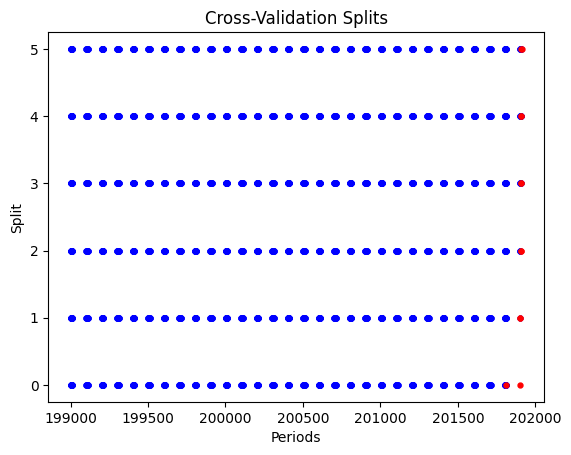

In [ ]:
model_y = RandomForestRegressor(n_estimators=120, max_depth=9, min_samples_leaf=5)
model_t = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=7)


train_data = df_phased[df_phased['period'] < 201912]
T = train_data[f'pa_lag0']
Y = train_data['violence_intensity']

all_covariates = []

for lag in range(0, 13):
    lagged_covariates = [f'{cov}_lag{lag}' for cov in base_covariates]
    all_covariates.extend(lagged_covariates)
all_covariates.extend(one_hot_encoded_list)
X = train_data[all_covariates]

X_base = train_data[[
    'populationwb_lag0', 'since_anyviolence_lag0', 'since_armedconf_lag0', 'since_civilwar_lag0',
    'tokens_lag0', 'obs_lag0', 'sentiment_words_lag0', 'uncertainty_lag0', 'ste_theta0_lag0', 'ste_theta1_lag0',
    'ste_theta2_lag0', 'ste_theta3_lag0', 'ste_theta4_lag0', 'ste_theta5_lag0', 'ste_theta6_lag0', 'ste_theta7_lag0',
    'ste_theta8_lag0', 'ste_theta9_lag0', 'ste_theta10_lag0', 'ste_theta11_lag0', 'ste_theta12_lag0',
    'ste_theta13_lag0', 'ste_theta14_lag0', 'ste_theta0_stock_lag0', 'ste_theta1_stock_lag0',
    'ste_theta2_stock_lag0', 'ste_theta3_stock_lag0', 'ste_theta4_stock_lag0', 'ste_theta5_stock_lag0',
    'ste_theta6_stock_lag0', 'ste_theta7_stock_lag0', 'ste_theta8_stock_lag0', 'ste_theta9_stock_lag0',
    'ste_theta10_stock_lag0', 'ste_theta11_stock_lag0', 'ste_theta12_stock_lag0', 'ste_theta13_stock_lag0',
    'ste_theta14_stock_lag0', 'sentiment_stock_lag0'
]]


periods = train_data['period']
unique_sorted_periods = pd.Series(periods.unique()).sort_values()

panel_split = PanelSplit(
    periods,
    unique_periods=unique_sorted_periods,
    n_splits=6,
    gap=0,
    test_size=2,
    plot=True
)

In [ ]:
#dict to store results for each lag
lag_results = {}

# Iterate over each lag in the specified range
for lag in range(1, 13):
    # Select only the covariates with the current lag suffix
    current_lagged_covariates = [f'{cov}_placebo_lag{lag}' for cov in covariates] + one_hot_encoded_list
    X_lagged = train_data[current_lagged_covariates]  # Filter only current lag columns

    # Update T to use the lag-specific treatment column
    T = train_data[f'pa_placebo_lag{lag}']

    # Call the function and store the result
    result = modeling.dml_process_treatment(X_base, X_lagged, Y, T, model_y, model_t, panel_split, lag)
    # Store the result in the dictionary with the lag as the key
    lag_results[lag] = result
    print(f"Placebo Lag {lag} done!")
    print(result)

Lag 1 results - Theta: -0.03724083728273407, CI: (-0.1359505778108106, 0.061468903245342474)
Placebo Lag 1 done!
{'theta': -0.03724083728273407, 'ci_lower': -0.1359505778108106, 'ci_upper': 0.061468903245342474, 'neg_mse_avg': -0.0036453248182645626, 'auc_avg': 0.9667065122280653}
Lag 2 results - Theta: 0.012856980944068584, CI: (-0.038627594635448376, 0.06434155652358554)
Placebo Lag 2 done!
{'theta': 0.012856980944068584, 'ci_lower': -0.038627594635448376, 'ci_upper': 0.06434155652358554, 'neg_mse_avg': -0.003480396567022438, 'auc_avg': 0.955010274798747}
Lag 3 results - Theta: -0.009075380774944566, CI: (-0.057897837723096646, 0.03974707617320751)
Placebo Lag 3 done!
{'theta': -0.009075380774944566, 'ci_lower': -0.057897837723096646, 'ci_upper': 0.03974707617320751, 'neg_mse_avg': -0.003382727903668642, 'auc_avg': 0.9470148592516204}
Lag 4 results - Theta: -0.007455919225938995, CI: (-0.05825563707850274, 0.04334379862662475)
Placebo Lag 4 done!
{'theta': -0.007455919225938995, 'ci_

In [ ]:
lag_results_df = pd.DataFrame(lag_results).T

#set index to col named 'lag'
lag_results_df.reset_index(inplace=True)
lag_results_df.rename(columns={'index': 'lag'}, inplace=True)
lag_results_df.head()

,lag,theta,ci_lower,ci_upper,neg_mse_avg,auc_avg
0,1,-0.037241,-0.135951,0.061469,-0.003645,0.966707
1,2,0.012857,-0.038628,0.064342,-0.003480,0.955010
2,3,-0.009075,-0.057898,0.039747,-0.003383,0.947015
3,4,-0.007456,-0.058256,0.043344,-0.003490,0.956225
4,5,0.020425,-0.055747,0.096597,-0.003484,0.953668


In [ ]:
#set numbers in the lag column to negative
lag_results_df['lag'] = -lag_results_df['lag']

lag_results_df.head()

,lag,theta,ci_lower,ci_upper,neg_mse_avg,auc_avg
0,-1,-0.037241,-0.135951,0.061469,-0.003645,0.966707
1,-2,0.012857,-0.038628,0.064342,-0.003480,0.955010
2,-3,-0.009075,-0.057898,0.039747,-0.003383,0.947015
3,-4,-0.007456,-0.058256,0.043344,-0.003490,0.956225
4,-5,0.020425,-0.055747,0.096597,-0.003484,0.953668


In [ ]:
# Load the dictionary from the file
with open(path_in_ + 'lag_results.pkl', 'rb') as file:
    lag_results = pickle.load(file)

print(lag_results)

og_lag_results_df = pd.DataFrame(lag_results).T
#set index to col named 'lag'
og_lag_results_df.reset_index(inplace=True)
og_lag_results_df.rename(columns={'index': 'lag'}, inplace=True)
og_lag_results_df.head()

{0: {'theta': -0.0346349477964568, 'ci_lower': -0.1217969776607257, 'ci_upper': 0.05252708206781209, 'neg_mse_avg': -0.003822982168463956, 'auc_avg': 0.966940613184572}, 1: {'theta': -0.05106659166420041, 'ci_lower': -0.09805726716402838, 'ci_upper': -0.004075916164372438, 'neg_mse_avg': -0.00394926415896337, 'auc_avg': 0.9651805568229882}, 2: {'theta': -0.07354763046729478, 'ci_lower': -0.14179754257632632, 'ci_upper': -0.0052977183582632315, 'neg_mse_avg': -0.0037174476427650253, 'auc_avg': 0.9630564842929704}, 3: {'theta': -0.0657537203194512, 'ci_lower': -0.12831536319914388, 'ci_upper': -0.003192077439758509, 'neg_mse_avg': -0.004018275678552379, 'auc_avg': 0.9598997236352256}, 4: {'theta': -0.06444321681394505, 'ci_lower': -0.10522744018365249, 'ci_upper': -0.0236589934442376, 'neg_mse_avg': -0.003842463654762672, 'auc_avg': 0.9641225480643275}, 5: {'theta': -0.03855393463358625, 'ci_lower': -0.07641266135862085, 'ci_upper': -0.0006952079085516469, 'neg_mse_avg': -0.0036989063440

,lag,theta,ci_lower,ci_upper,neg_mse_avg,auc_avg
0,0,-0.034635,-0.121797,0.052527,-0.003823,0.966941
1,1,-0.051067,-0.098057,-0.004076,-0.003949,0.965181
2,2,-0.073548,-0.141798,-0.005298,-0.003717,0.963056
3,3,-0.065754,-0.128315,-0.003192,-0.004018,0.959900
4,4,-0.064443,-0.105227,-0.023659,-0.003842,0.964123


In [ ]:
#combine the dfs
lag_results_df = pd.concat([og_lag_results_df, lag_results_df])
lag_results_df.head()

,lag,theta,ci_lower,ci_upper,neg_mse_avg,auc_avg
0,0,-0.034635,-0.121797,0.052527,-0.003823,0.966941
1,1,-0.051067,-0.098057,-0.004076,-0.003949,0.965181
2,2,-0.073548,-0.141798,-0.005298,-0.003717,0.963056
3,3,-0.065754,-0.128315,-0.003192,-0.004018,0.959900
4,4,-0.064443,-0.105227,-0.023659,-0.003842,0.964123


In [ ]:
lag_results_df.tail()

,lag,theta,ci_lower,ci_upper,neg_mse_avg,auc_avg
7,-8,0.006166,-0.063543,0.075875,-0.003648,0.958686
8,-9,-0.023830,-0.114693,0.067033,-0.003628,0.949581
9,-10,-0.012852,-0.037604,0.011900,-0.003639,0.946012
10,-11,-0.054183,-0.146595,0.038229,-0.003695,0.946940
11,-12,0.012678,-0.076318,0.101674,-0.003755,0.949262


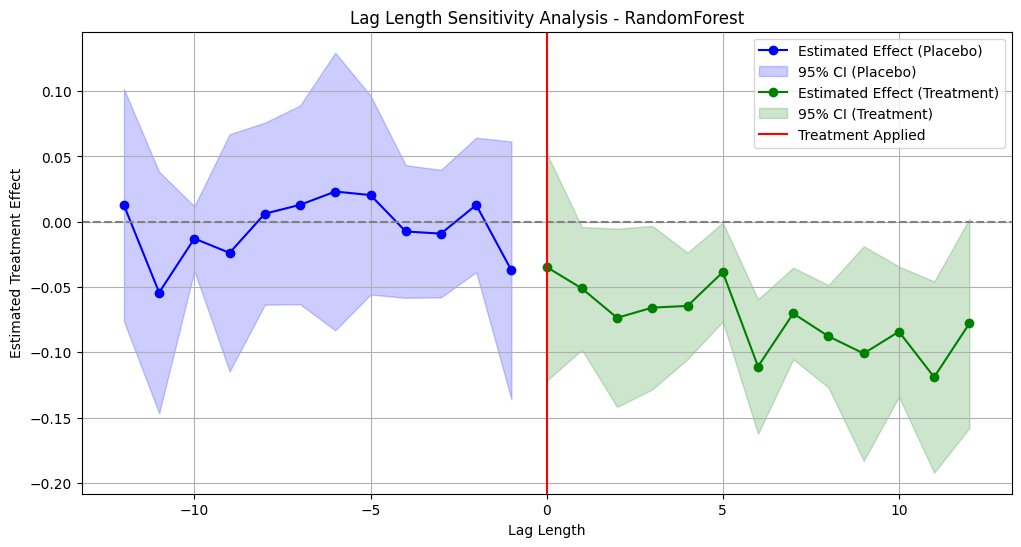

In [ ]:
# Define the plot function
def enhanced_sensitivity_analysis_test(df, learner='RandomForest'):
    df = df.sort_values('lag')
    lags = df['lag']
    effects = df['theta']
    conf_lower = df['ci_lower']
    conf_upper = df['ci_upper']

    # Plotting the effects and confidence intervals
    plt.figure(figsize=(12, 6))

    # Pre-treatment (placebo lags)
    plt.plot(lags[lags < 0], effects[lags < 0], marker='o', label='Estimated Effect (Placebo)', color='blue')
    plt.fill_between(lags[lags < 0], conf_lower[lags < 0], conf_upper[lags < 0], color='blue', alpha=0.2, label='95% CI (Placebo)')

    # Post-treatment (actual treatment lags)
    plt.plot(lags[lags >= 0], effects[lags >= 0], marker='o', label='Estimated Effect (Treatment)', color='green')
    plt.fill_between(lags[lags >= 0], conf_lower[lags >= 0], conf_upper[lags >= 0], color='green', alpha=0.2, label='95% CI (Treatment)')

    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='red', linestyle='-', label='Treatment Applied')
    plt.xlabel('Lag Length')
    plt.ylabel('Estimated Treatment Effect')
    plt.title(f'Lag Length Sensitivity Analysis - {learner}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the enhanced sensitivity analysis test
enhanced_sensitivity_analysis_test(lag_results_df)